In [83]:
#!/usr/bin/env python3
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools
import scipy.special
from decimal import *
import unittest as ut
from sympy.solvers import solve
from sympy import Symbol
from sympy import zoo
from scipy.constants import golden as phi

import sys
sys.version

'3.8.10 (default, Mar 15 2022, 12:22:08) \n[GCC 9.4.0]'

In [2]:
#import warnings
#warnings.filterwarnings('ignore')
#warnings.filterwarnings('default')

# Profitability of forks and attacks

We base our profitability evaluation of attacks on the evaluation in the [Whale attack paper](https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf).
Therefore, we start by looking at their evaluation in detail and then improve their model.

# 1. Reproduce whale attack costs

According to the [Whale attack paper](https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf), the value for the additional bribing cost $ \epsilon $ (in the original paper denoted as $ \delta $) i.e., the bribe, is estimated as follows.

* Let $ \alpha $ be the hashrate of the attacker that works on the attack branch unconditionally 
* Let $ \beta $ be the hashrate of the other miners, some of which beeing rational i.e., $ \alpha + \beta = 1 $ 
* Let $ \beta_m $ be the hashrate of an individual miner which has to decide if he should follow the attack branch or not
* Let $ z $ be the number of blocks that the attack chain is behind the main chain when the race phase starts

Expected reward for $ \beta_m $ if **not joining** the attack, for **one new** block on the main chain if *attack fails*. Value in number of block rewards (normalized to $ 1 $):
$$
\begin{align}
  \frac{ \big( 1 - \big(
                        \frac{\alpha}
                             {\beta}
                   \big)^{z+1} 
         \big) \cdot \beta_m}
       {\beta}
\end{align}
$$

Expected reward for $ \beta_m $ if **joining** the attack, for **one new** block on the attack chain if *attack succeeds*. Value in number of block rewards (normalized to $ 1 $):
\begin{align}
  \frac{ \big( \frac{\alpha + \beta_m}
                    {\beta - \beta_m}
         \big)^{z+1} \cdot \beta_m}
       {\alpha + \beta_m} 
       \cdot ( \epsilon + 1 )
\end{align}

Solved for $ \epsilon $:
$$
\begin{align}
  \epsilon > \frac{ \big( 1 - \big(\frac{\alpha}{\beta}\big)^{z+1} \big)}
                  {\beta} 
             \cdot 
             \frac{ \alpha + \beta_m} 
                  { \big(\frac{\alpha + \beta_m}{\beta - \beta_m}\big)^{(z+1)}}
             -1
\end{align}
$$

In [3]:
def whale_attack_bribe(alpha,beta_m,z,beta=None):
    if beta is None:
        beta = 1 - alpha
        #beta = 1 - (alpha + beta_m) # yields wrong results 
    return ( (1-(alpha/beta)**(z+1))/beta ) * ( (alpha + beta_m)/ ( (alpha+beta_m)/(beta - beta_m) )**(z+1) ) - 1 

## 1.1 Compare values with paper
See table 1 in [Whale attack paper](https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf) for values:

In [4]:
assert math.isclose(whale_attack_bribe(alpha=0.1,beta_m=0.05,z=6.),31270.040)

In [5]:
assert round(whale_attack_bribe(alpha=0.2,beta_m=0.05,z=6),2) == 682.4 
# compare with table 682.4

In [6]:
assert round(whale_attack_bribe(alpha=0.05,beta_m=0.05,z=1),2) == 7.5 
# compare with 7.5

In [7]:
assert round(whale_attack_bribe(alpha=0.2,beta_m=0.05,z=1),2) == 1.64
# compare with 1.64 

In [8]:
t1_alpha=0.15
t1_beta_m=0.10
t1_beta= 1 - t1_alpha
assert round(whale_attack_bribe(t1_alpha,beta_m=t1_beta_m,z=1,beta=t1_beta),2) == 1.56

Looks good so far, now check for strange values, actually $ \beta_m $ should not be zero as it is the perspective of this miner ($ m $), which should be considered here:

In [9]:
whale_attack_bribe(alpha=0.05,beta_m=0,z=1) # This must not work at all!

17.94736842105263

In [10]:
whale_attack_bribe(alpha=0,beta_m=0.05,z=1)

17.049999999999997

Let's insert an assertion that $ \beta_m > 0 $ to fix this

In [11]:
def whale_attack_bribe(alpha,beta_m,z,beta=None):
    assert beta_m > 0.0
    if beta is None:
        beta = 1 - alpha
        #beta = 1 - (alpha + beta_m) # yields wrong results 
    return ( (1-(alpha/beta)**(z+1))/beta ) * ( (alpha + beta_m)/ ( (alpha+beta_m)/(beta - beta_m) )**(z+1) ) - 1 

In [12]:
try:
    whale_attack_bribe(alpha=0.05,beta_m=0,z=1)
    assert False
except AssertionError:
    assert True

In [13]:
t1_alpha=0.15
t1_beta_m=0.10
t1_beta= 1 - t1_alpha
assert round(whale_attack_bribe(t1_alpha,beta_m=t1_beta_m,z=1,beta=t1_beta),2) == 1.56

In [14]:
t1_alpha=0.15
t1_beta_m=0.10
t1_beta= 1 - (t1_alpha + t1_beta_m)
assert round(whale_attack_bribe(t1_alpha,beta_m=t1_beta_m,z=1,beta=t1_beta),2) == 1.16

# 2. Translate original model to our explicit notation for *infinite* attack duration

Again we start of by adapting the whale attack to fit our model which should include
already mined blocks. 

* Let $ p_\mathcal{B} $ be the hashrate of the *attacker/byzantine* (which certainly stays on the attacker branch as it is his attack/fork). In most of our evaluation this will be set to$ p_\mathcal{B} = 0 $. 
* Let $ p_\mathcal{E} $ be the estimated rational hashrate of the other bribable (*evil*) miners which are assumed to work on the attacker branch as well.
* Let $ p_\mathcal{A} $ be the hashrate of *altruistic* (honest) miners which will never accept a bribe to work on the attacker branch, but they will work on the attack branch if it becomes the longest branch. 
* Let $ p_\mathcal{V} $ be the hashrate of the *victim*. This portion of the rational hashrate  is aussmed to stay on the main chain, even if the attack chain has become the longest chain, as it is economically rational for them to do so e.g., because they would lose money if the attack is successful.
* Let $ p_\mathcal{I} $ be the hashrate of *indifferent* rational miners, which currently will work on the attack branch if it becomes the longest branch. For most calculations this can be merged with $ p_\mathcal{A} $, but our model wants to make the distincion explicit. The difference is that $ p_\mathcal{I} $ might at some point become part of either $ p_\mathcal{E} $ or $ p_\mathcal{V} $. 
* Let $ p_m $ be the hashrate of an *individual rational/bribable miner* ($M$) which has to decide if he should follow the attack branch or not:
$$ 
p_m + p_\mathcal{B} + p_\mathcal{E} + p_\mathcal{I} + p_\mathcal{V} + p_\mathcal{A} = 1 
$$ 
* Let $ z $ be the number of blocks that attack chain is behind the attack chain when the race phase starts. In case of exlcusion attacks $ z = 1 $

Probability that an **infinitly ongoing attack** either *fails* or *succeeds* without accounting for $ p_m $:

$$
\begin{align}
\Pr(\text{attack fail}) &:= 1 - \left(
                                \frac{p_\mathcal{B} + p_\mathcal{E}}
                                     {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I}}
                           \right)^{z+1} \\
\,
\Pr(\text{attack success}) &:= \left(
                                \frac{p_\mathcal{B} + p_\mathcal{E}}
                                     {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I}}
                             \right)^{z+1}
\end{align}
$$

Considering $ p_m $ **joining** the attack/fork:

$$
\begin{align}
\Pr(\text{fail join}) &:= 1 - \left(
                                \frac{p_\mathcal{B} + p_\mathcal{E} + p_m}
                                     {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I}}
                           \right)^{z+1} \\
\,
\Pr(\text{success join}) &:= \left(
                                \frac{p_\mathcal{B} + p_\mathcal{E} + p_m}
                                     {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I}}
                             \right)^{z+1}
\end{align}
$$

Considering $ p_m $ **abstains** from the attack and thus is working against the attack while *staying on the main chain*. What is the **success of the attack** if $ p_m $ abstains and what is the proabability of the attack failing:

$$
\begin{align}
\Pr(\text{success abstain}) &:= \left(
                                \frac{p_\mathcal{B} + p_\mathcal{E}}
                                     {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                             \right)^{z+1} \\
\,                             
\Pr(\text{fail abstain}) &:= 1 - \left(
                                \frac{p_\mathcal{B} + p_\mathcal{E}}
                                     {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                           \right)^{z+1}                           
\end{align}
$$

In [15]:
#extract source to .py file later:
def Pr_success_join(p_B=0,p_E=0,p_A=None,p_V=0,p_I=0,p_m=0,z=1):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    q = p_B + p_E + p_m
    p = p_A + p_V + p_I
    if (q >= 0.5):
        return 1.0
    return ( q/(1-q) )**(z+1)

In [16]:
#extract source to .py file later:
def Pr_success_abstain(p_B=0,p_E=0,p_A=None,p_V=0,p_I=0,p_m=0,z=1):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    q = p_B + p_E 
    p = p_A + p_V + p_I + p_m
    if (q >= 0.5):
        return 1.0
    return ( q/(1-q) )**(z+1)

So far, this is equivalent to the general *infinite catch up* condition $ a_z $ from:
    
* "Analysis of hashrate-based double spending" (https://arxiv.org/pdf/1402.2009.pdf)
* "Bitcoin: A Peer-to-Peer Electronic Cash System" (https://bitcoin.org/bitcoin.pdf)

Classical parameter names and notation from these papers:
* $p$ = hashrate of the honest network
* $q$ = hashrate of the attacker, where $ p + q = 1 $
* $n$ = number of confirmation blocks, *including and on top of* the block which includes the respective transaction which needs to be confirmed or double-spend respectively

The probability to **ever** catch-up if $ z $ blocks behind, where one block is added to $z$ when the honest miners find a block and one block is substracted from $ z $ when the attacker finds a block i.e.,

The catch-up probability is a simplification of the *recurrance relation*, where $ q = \alpha $ and $ p = \beta $, given as:
$$
\begin{align}
    a_z &:= p \cdot a_{z+1} + q \cdot a_{z-1} \\
        &:= min(q/q,1)^{max(z+1,0)} 
\end{align}
$$

In [17]:
def catch_up(q,z):
    if q >= 0.5:
        return 1.0
    return ( q/(1-q) )**(z+1)

In [18]:
assert Pr_success_join(p_m=0.4,z=1) == catch_up(q=0.4,z=1)
Pr_success_join(p_m=0.4,z=1)

0.44444444444444453

In [19]:
assert Pr_success_join(p_m=0.5,z=1) == catch_up(q=0.5,z=1)
Pr_success_join(p_m=0.5,z=1)

1.0

In [20]:
assert Pr_success_abstain(p_m=0.4,z=1) == catch_up(q=0.0,z=1)
Pr_success_abstain(p_m=0.4,z=1)

0.0

In [21]:
assert Pr_success_abstain(p_E=0.1,p_m=0.4,z=1) == catch_up(q=0.1,z=1)
Pr_success_abstain(p_E=0.1,p_m=0.4,z=1)

0.01234567901234568

Thus, the expected profit $ \rho $, i.e., the expected extractable value of $ M $, for *the next block* on the **main chain** (normalized to 1) is given by the following formular.
Hereby the counter-probability of the success probability of the attack to succeed when $ p_m $ abstains is used to get the probability of the attack failing in this case. The rest is the normal probability of mining a new block on the main chain in the given setting, conditioned on the attack failing. 

$$
    \rho_{main} = EV_m(main) := \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                        {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m} 
$$

The expected profit $ \rho $, i.e., the expected extractable value of $ M $, for *the next block* on the **attack chain** (normalized to 1) is given by:

$$
\begin{align}
  \rho_{fork} = EV_m(fork) := \frac{\Pr(\text{success join}) 
                        \cdot p_m}
                       {p_\mathcal{B} + p_\mathcal{E} + p_m} 
                  \cdot ( \epsilon + 1 )
\end{align}
$$

Hereby, $ \epsilon $ is a bribe which is only paied for blocks on the attackchain.

In [22]:
#extract to .py file later:
def EV_main(p_B=0,p_E=0,p_A=None,p_V=0,p_I=0,p_m=0,z=1):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P = Pr_success_abstain(p_B=p_B,
                           p_E=p_E,
                           p_A=p_A,
                           p_V=p_V,
                           p_I=p_I,
                           p_m=p_m,
                           z=z)
    return ( 
              ( 
                  (( 1 - P ) * p_m )
                  / ( p_A + p_V + p_I + p_m ) 
              ) 
           )

In [23]:
#extract to .py file later
def EV_fork(p_B=0,p_E=0,p_A=None,p_V=0,p_I=0,p_m=0,z=1,epsilon=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P = Pr_success_join(p_B=p_B,
                        p_E=p_E,
                        p_A=p_A,
                        p_V=p_V,
                        p_I=p_I,
                        p_m=p_m,
                        z=z)
    return (
                (
                   ( 
                      (P * p_m)/
                      ( p_B + p_E + p_m )
                   ) * ( epsilon + 1 ) 
                )
           )

For a case where **no one attacks**, and thus there is no fork, this boils down to the classic expected reward for the main chain (as $ p_\mathcal{B} = p_\mathcal{E} = p_\mathcal{I} = p_\mathcal{V} = 0 $), which is the fraction of the individual mining power $ p_m $.
$$
\begin{align}
    \rho_{main} = EV_m(main) &:= \frac{ \left( 1 - \big(\frac{0}{(1-p_m)+p_m}\big)^{z+1}
                          \right) \cdot p_m}
                        { (1-p_m) + p_m }\\
                &:= p_m
\end{align}
$$

In [24]:
EV_main(p_m=0.3,z=0)

0.3

In [25]:
EV_main(p_m=0.3,z=1)

0.3

In [26]:
EV_main(p_m=0.3,z=100) # z is irrelevant since no one attacks an thus no fork can exist 

0.3

In [27]:
EV_main(p_m=0.6,z=0)

0.6

In [28]:
EV_main(p_m=0.6,z=1)

0.6

If $ p_m $ is the **only attacker** this boils down to the classical catch up condition,
as (as $ p_\mathcal{B} = p_\mathcal{E} = p_\mathcal{I} = p_\mathcal{V} = \epsilon = 0 $):
$$
  \begin{align}
\rho_{fork} = EV_m(fork) &:= 
                    \frac{\big(\frac{p_m}{1-p_m}\big)^{z+1}
                          \cdot p_m}
                          {p_m} 
                   \cdot ( 0 + 1 ) \\
                &:= \left(\frac{p_m}{1-p_m}\right)^{z+1}
  \end{align}
$$

In [29]:
EV_fork(p_m=0.3,z=1)

0.18367346938775514

In [30]:
catch_up(q=0.3,z=1)

0.18367346938775514

In [31]:
EV_fork(p_m=0.5,z=1)

1.0

## 2.1 Minimum attack bribe $\epsilon$ *infinte* case

The minimum attack bribe can be calculated as follows:
$$
\begin{align}
                  \frac{\Pr(\text{success join}) 
                        \cdot p_m}
                       {p_\mathcal{B} + p_\mathcal{E} + p_m} 
                  \cdot ( \epsilon + 1 ) 
                  &>
                  \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                   {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}\\
                  \epsilon  
                  &>
                  \frac{
                        \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                        {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                       }
                       {\frac{\Pr(\text{success join}) 
                        \cdot p_m}
                        {p_\mathcal{B} + p_\mathcal{E} + p_m}
                       }-1\\
\end{align}
$$

The required bribe in our notation is thus calculated by rearragning the inequality as follows:
$$
\epsilon > \frac{ \big( 1 - \big(   
                                \frac{p_\mathcal{B} + p_\mathcal{E}}
                                     {p_\mathcal{A} + p_\mathcal{V} + 
                                      p_\mathcal{I} + p_m}
                            \big)^{z+1} 
                  \big)}
               {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m } 
             \cdot 
             \frac{ p_\mathcal{B} + p_\mathcal{E} + p_m} 
                  { \big(
                      \frac{p_\mathcal{B} + p_\mathcal{E} + p_m}
                           {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I}}
                     \big)^{z+1}} -1
$$

In [32]:
def e_min_check(p_B=0,
                p_E=0,
                p_A=None,
                p_V=0,
                p_I=0,
                p_m=0,
                z=1):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    return (
             ( (1 - (
                       ( 
                         (p_B + p_E)/
                         (p_A + p_V + p_I + p_m)
                       )**(z+1) 
                   ))/
                   (
                       (p_A + p_V + p_I + p_m)
                   )
             )*
             (
                 (p_B + p_E + p_m)/
                 (
                     (p_B + p_E + p_m)/
                     (p_A + p_V + p_I)
                 )**(z+1) 
             ) - 1
           )

In [33]:
#extract to .py file later
def e_min(p_B=0,
          p_E=0,
          p_A=None,
          p_V=0,
          p_I=0,
          p_m=0,
          z=1):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P_join = Pr_success_join(p_B=p_B,
                         p_E=p_E,
                         p_A=p_A,
                         p_V=p_V,
                         p_I=p_I,
                         p_m=p_m,
                         z=z)
    
    P_abstain = Pr_success_abstain(p_B=p_B,
                           p_E=p_E,
                           p_A=p_A,
                           p_V=p_V,
                           p_I=p_I,
                           p_m=p_m,
                           z=z)
    """
    return (
             (  (1 - ( Pa))/
                (
                 (p_A + p_V + p_I + p_m)
                )
             )*
             (
                 (p_B + p_E + p_m)/
                 (
                     Pj
                 ) 
             ) - 1
           )
    """
    return (
             (  
                ((1 - P_abstain) * p_m)/
                (p_A + p_V + p_I + p_m)
             )/
             (
                 (P_join * p_m)/
                 (p_B + p_E + p_m)
             ) - 1
           )

In [34]:
assert e_min_check(p_m=0.2,z=1) == e_min(p_m=0.2,z=1)

In [35]:
e_min(p_m=0.2,z=1)

2.2

In [36]:
assert e_min_check(p_E=0.4,p_m=0.1,z=1) == e_min(p_E=0.4,p_m=0.1,z=1)

# 3. The $ 1/\phi^2 $ bound in the *infinite* case

Interestingly with $ 38.2 \% $ hashrate an attack/fork is profitable without any additional bribe under certain conditions.

In [37]:
whale_attack_bribe(alpha=0,beta_m=0.382,z=1) # observe that the original whale attack calculation yields negative e

-0.00019895287958116015

In [38]:
whale_attack_bribe(alpha=0,beta_m=0.3819660112501051,z=1) # small bribe needed

4.440892098500626e-16

In [39]:
whale_attack_bribe(alpha=0,beta_m=0.3819660112501052,z=1) # no bribe needed

-4.440892098500626e-16

In our notation the same values can be derived in the following way:

In [40]:
e_min(p_B=0,p_E=0,p_V=0,p_I=0,p_m=0.382,z=1)

-0.00019895287958116015

In [41]:
e_min(p_B=0,p_E=0,p_V=0,p_I=0,p_m=0.3819660112501051,z=1)

4.440892098500626e-16

In [42]:
e_min(p_B=0,p_E=0,p_V=0,p_I=0,p_m=0.3819660112501052,z=1)

-4.440892098500626e-16

The reason for this lies in the calculation of the success probability for infinite catch up. 
$ 38.196601125010515... \%$ is also the threshold when the probability to catch-up one block becomes greater than the individual hashrate of a miner $ m $:

In [43]:
catch_up(q=0.381966011250105,z=1) # success probability lower than hashrate

0.38196601125010465

In [44]:
catch_up(q=0.38196601125010515,z=1) # success probability equal to hashrate

0.3819660112501051

In [45]:
catch_up(q=0.3819660112501052,z=1) # success probability higher than hashrate

0.3819660112501054

In [46]:
catch_up(q=0.38,z=1)

0.3756503642039542

In our notation the same values can be derived in the following way:

In [47]:
EV_fork(p_B=0,p_E=0,p_V=0,p_I=0,p_m=0.38,z=1,epsilon=0)

0.37565036420395426

In [48]:
Pr_success_join(p_B=0,p_E=0,p_V=0,p_I=0,p_m=0.38,z=1)

0.3756503642039542

We now can solve for the point where mining on the attack/fork chain 
becomes more profitable than honest mining with the respective hashrate of miner $ m $.
This is exactly the point, where the actual hashrate is equivalent to the expected success probability. 

Therefore, we replace $ y $ in the catch_up functions with $ y $ in the linar function, which is $ x $ and solve the resulting equation.
Therefore, we have to rearange first s.t. we can use sympy solver. 
$$
\begin{align}
y &= x \\
y &= \left(\frac{x}{(1-x)}\right)^2  \\
x &= \left(\frac{x}{(1-x)}\right)^2  \\
0 &= \left(\frac{x}{(1-x)}\right)^2 - x\\
\end{align}
$$

In [49]:
from sympy.solvers import solve
from sympy import Symbol
x = Symbol('x')
solve(((x/(1-x))**2)-x, x)

[0, 3/2 - sqrt(5)/2, sqrt(5)/2 + 3/2]

In [50]:
3/2 - math.sqrt(5)/2

0.3819660112501051

Which is exaclty $ 1/\phi^2 $

In [51]:
from scipy.constants import golden as phi
assert phi == (1 + 5 ** 0.5) / 2
1/phi**2

0.38196601125010515

We now plot this bound as a comparision between the profitability of honst mining, and the profitability of a z=1 fork:

/tmp/ipykernel_2427724/1429032508.py:22: RuntimeWarning: invalid value encountered in double_scalars
  (P * p_m)/


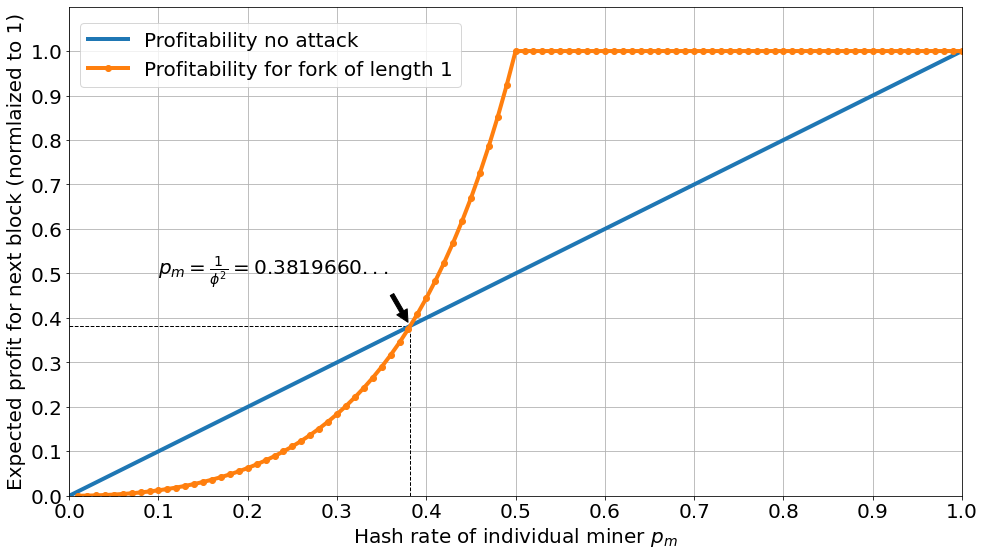

In [84]:
def phi_bound():
    p_B = 0
    p_E = 0
    p_A = None
    p_V = 0
    p_I = 0
    z = 1
    epsilon = 0
    #omega_m = [ 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.382, 0.4, 0.45, 0.47, 0.49, 0.5, 0.55 ]
    #omega_m = [ o_m for o_m in np.arange(0.0,0.65,0.01) ]
    p_m = [ p_i for p_i in np.arange(0.0,1.1,0.01) ]
    
    fig, ax = plt.subplots(figsize=(16, 9))
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))

    # draw lines to indicate intersection
    #plt.plot([x1, x2], [y1, y2], color='k', linestyle='-', linewidth=2)
    plt.plot([0.3819, 0.3819], [0, 0.3819], color='k', linestyle='--', linewidth=1)
    plt.plot([0, 0.3819], [0.3819, 0.3819], color='k', linestyle='--', linewidth=1)
    
    # profit main chain without any attack i.e., std. reward
    profit_main = [ EV_main(p_B=p_B,
                            p_E=p_E,
                            p_A=p_A,
                            p_V=p_V,
                            p_I=p_I,
                            p_m=p_i,
                            z=z) for p_i in p_m ]   
    plt.plot(p_m, 
             profit_main, 
             marker=',', 
             linewidth=4, 
             label="Profitability no attack")
    
    # profit attack chain with a fork of length z=1
    profit_attack = [ EV_fork(p_B=p_B,
                              p_E=p_E,
                              p_A=p_A,
                              p_V=p_V,
                              p_I=p_I,
                              p_m=p_i,
                              z=z,
                              epsilon=epsilon) for p_i in p_m ]
    plt.plot(p_m, 
             profit_attack, 
             marker='o', 
             linewidth=4, 
             label="Profitability for fork of length 1")
    
    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='center right', bbox_to_anchor=(0.45, 0.90))
    #ax.set_title("Profitability")
    ax.set_xlabel("Hash rate of individual miner $ p_m $")
    ax.set_ylabel("Expected profit for next block (normlaized to 1)")
    
    ax.annotate('$ p_m = \\frac{1}{\\phi^2} = 0.3819660... $', 
                xy=(0.3819, 0.3819), 
                xytext=(0.1, 0.5),
                arrowprops=dict(facecolor='black', shrink=0.1))
    
    ax.set_ylim([0.0, 1.1])
    ax.set_xlim([0,1.0]) 
    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 20})
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.savefig("../paper/preprint/figures/phi.png", dpi=200) 
    plt.show()

phi_bound()

# 4. Improve the model
So far we have only changed to notation of the original model from the the [Whale attack paper](https://www.cs.umd.edu/~jkatz/papers/whale-txs.pdf) and showed its correctness as well as highlighted the origin of the $ 38.2\%$ bound. 

Now we want to improve upon the original model in three dimensions: 
* First, by also accounting for *blocks which have already been minded* on the main chain, or the fork, as these blocks would be lost in case the other chain wins.
    + In the process, we also account for a scenario in which an attack compensates unconditionally for every contributed block to the attack chain.
* Second, by accounting for *finite attacks*, as these are the attacks which are relevant in practise. 
* Third, by also accounting for *rational victims*, which do not immediatly switch to the attack chain if it becomes the new longest (main) chain.

## 4.1 Account for already mined blocks
Again we start of by adapting the whale attack in our notation and enhance it by including already mined blocks in the equation. 

* Let $ \eta_{main} $ be the number of blocks contribued to the main chain since the fork
* Let $ \eta_{fork} $ be the number of blocks contribued to the fork chain since the fork

Now lets calculate the expected profit for a new block on the respective chain, given that there are also already contributed blocks which otherwise get stale if the other chain wins.
Therefore, we add the blocks which have already been produced on the chain times the probability that the respective chain wins. 


Expected profit in number of block rewards (normalized to $ 1 $) for *one new block on the __main__ chain* if **attack fails**: 
$$
  EV_m(\texttt{main blocks}) := \\
  \frac{ \big( 1 - \Pr(\text{success abstain})
         \big) \cdot p_m}
       {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
   + \big( \eta_{main} 
            \cdot  
            \left( 1 - \Pr(\text{success abstain})
            \right)
     \big)
   + \left( \Pr(\text{success abstain}) \cdot \eta_{fork} \right)
$$

In [53]:
#extract to .py file later
def EV_main_blocks(p_B=0,
                   p_E=0,
                   p_A=None,
                   p_V=0,
                   p_I=0,
                   p_m=0,
                   z=1,
                   n_main=0,
                   n_fork=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    assert z >= 0
    assert n_main >= 0
    
    P = Pr_success_abstain(p_B=p_B,
                           p_E=p_E,
                           p_A=p_A,
                           p_V=p_V,
                           p_I=p_I,
                           p_m=p_m,
                           z=z)
    return ( 
              ( 
                  (( 1 - P ) * p_m )
                  / ( p_A + p_V + p_I + p_m ) 
              ) + ( n_main * ( 1 - P ) ) + ( n_fork * P )
           )

In [54]:
assert EV_main() == EV_main_blocks()
assert EV_main(p_m=0.1) == EV_main_blocks(p_m=0.1)
assert EV_main(p_m=0.1) < EV_main_blocks(p_m=0.1,n_main=1)

In [55]:
EV_main_blocks(p_m=0.1,n_main=1)

1.1

In [56]:
EV_main(p_m=0.1)

0.1

In [57]:
EV_main_blocks(p_m=0.1,p_E=0.1,n_main=1)

1.0973936899862826

In [58]:
EV_main_blocks(p_m=0.1,p_E=0.1,n_main=1,n_fork=1)

1.1097393689986284

In [59]:
EV_main_blocks(p_m=0.1,p_E=0.1,n_fork=1)

0.12208504801097393

In [60]:
EV_main_blocks(p_m=0.1,p_E=0.1)

0.10973936899862825

Expected profit in number of block rewards (normalized to $ 1 $) for *one new block on the __attack__ chain* if **attack succeeds**. This assumes that the bribe $ \epsilon $ is payed out on a per block basis, if there is any bribe ($ \epsilon > 0 $):

$$
  EV_m(\texttt{fork blocks}) := \\
  \left( 
       \frac{ \Pr(\text{success join}) \cdot p_m}
            {p_\mathcal{B} + p_\mathcal{E} + p_m} 
       \cdot 
       ( \epsilon + 1 )
  \right) + \big( 
                  \eta_{fork} 
                  \cdot 
                  ( \epsilon + 1 ) 
                  \cdot
                  \Pr(\text{success join})
            \big)
   + \big( 
                  \eta_{main} 
                  \cdot
                  ( 1 - \Pr(\text{success join}))
            \big)
$$

In [61]:
#extract to .py file later
def EV_fork_blocks(p_B=0,
                    p_E=0,
                    p_A=None,
                    p_V=0,
                    p_I=0,
                    p_m=0,
                    z=1,
                    epsilon=0,
                    n_fork=0,
                    n_main=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P = Pr_success_join(p_B=p_B,
                        p_E=p_E,
                        p_A=p_A,
                        p_V=p_V,
                        p_I=p_I,
                        p_m=p_m,
                        z=z)
    return (
                (
                   ( 
                      ( P  *  p_m ) / ( p_B + p_E + p_m ) 
                   ) * ( epsilon + 1 )
                ) + ( n_fork * P * ( epsilon + 1 ) ) + ( n_main * ( 1 - P ) )
            )

In [62]:
assert EV_fork(p_m=0.1) == EV_fork_blocks(p_m=0.1)
assert EV_fork(p_m=0.1) < EV_fork_blocks(p_m=0.1,n_fork=1)

In [63]:
EV_fork_blocks(p_m=0.1,n_fork=1)

0.02469135802469136

In [64]:
EV_fork(p_m=0.1)

0.01234567901234568

In [65]:
# check, if I have 0.5 of the total hashrate, 
# then in an attack with another attacker with 25% of
# the total hashrate, I have to make 2/3 of the overall profits
EV_fork_blocks(p_B=0.25,
                  p_E=0,
                  p_A=None,
                  p_V=0,
                  p_I=0,
                  p_m=0.5,
                  z=1,
                  epsilon=0,
                  n_fork=0)

0.6666666666666666

In [71]:
# if I have a block on both chains, I have profit 1 in any case
ev_one = EV_fork_blocks(p_B=0.25,
               p_E=0,
               p_A=None,
               p_V=0,
               p_I=0,
               p_m=0.0,
               z=1,
               epsilon=0,
               n_fork=1,
               n_main=1)
print(ev_one)
assert 1.0 == ev_one

1.0


In [81]:
#extract to .py file
def EV_compare_blocks():  
    p_E = 0
    p_A = None
    p_V = 0
    p_I = 0
    epsilon = 0
    p_m = [ p_i for p_i in np.arange(0.0,0.56,0.01) ]
    
    fig, ax = plt.subplots(figsize=(16, 9))
    # https://matplotlib.org/api/markers_api.html
    line = itertools.cycle(('.','-', '--', '-.'))
    marker = itertools.cycle((',','v', 'o', 's','.', '+', '*','1','D','x','^'))
    
    # profit main chain without any attack 
    profit_main = [ EV_main_blocks(p_B=0,
                                   p_E=p_E,
                                   p_A=p_A,
                                   p_V=p_V,
                                   p_I=p_I,
                                   p_m=p_i,
                                   z=0,
                                   n_main=0) for p_i in p_m ] 
    plt.plot(p_m, 
             profit_main, 
             marker=",", 
             linestyle='--',
             linewidth=4, 
             #label="Profit main no attack $p_\\mathcal{B}=0$ $\\eta_{main}=0$ $\\overleftarrow{k}=0$")
             label="Profit main chain, no attack $p_\\mathcal{B}=0$, $\\eta_{main}=0$, $\\eta_{attack}=0$, $z=0$")
             
    # profit main chain while beeing attacked 
    profit_main = [ EV_main_blocks(p_B=0.25,
                                   p_E=p_E,
                                   p_A=p_A,
                                   p_V=p_V,
                                   p_I=p_I,
                                   p_m=p_i,
                                   z=1,
                                   n_main=0) for p_i in p_m ] 
    plt.plot(p_m, 
             profit_main, 
             marker=",", 
             linestyle='--',
             linewidth=4, 
             label="Profit main chain while attacked $p_\\mathcal{B}=0.25$, $\\eta_{main}=0$, $\\eta_{attack}=0$, $z=1$")
    
    # profit main chain while beeing attacked when m has already contribued a block to main 
    profit_main = [ EV_main_blocks(p_B=0.25,
                                   p_E=p_E,
                                   p_A=p_A,
                                   p_V=p_V,
                                   p_I=p_I,
                                   p_m=p_i,
                                   z=1,
                                   n_main=1,
                                   n_fork=1) for p_i in p_m ] 
    plt.plot(p_m, 
             profit_main, 
             marker=",", 
             linestyle='--',
             linewidth=4, 
             label="Profit main chain while attacked $p_\\mathcal{B}=0.25$, $\\eta_{main}=1$, $\\eta_{attack}=1$, $z=1$")
    
    # profit attack chain if m is the only attacker
    profit_attack = [ EV_fork_blocks(p_B=0,
                                     p_E=p_E,
                                     p_A=p_A,
                                     p_V=p_V,
                                     p_I=p_I,
                                     p_m=p_i,
                                     z=1,
                                     epsilon=epsilon,
                                     n_fork=0) for p_i in p_m ]
    plt.plot(p_m, 
             profit_attack, 
             marker=next(marker), 
             linestyle='-',
             linewidth=4, 
             label="Profit attack chain (no other attacker) $p_\\mathcal{B}=0$, $\\eta_{main}=0$, $\\eta_{attack}=0$, $z=1$")
    
    # profit attack chain if there is another attacker
    profit_attack = [ EV_fork_blocks(p_B=0.25,
                                     p_E=p_E,
                                     p_A=p_A,
                                     p_V=p_V,
                                     p_I=p_I,
                                     p_m=p_i,
                                     z=1,
                                     epsilon=epsilon,
                                     n_fork=0) for p_i in p_m ]
    plt.plot(p_m, 
             profit_attack, 
             marker=next(marker), 
             linestyle='-',
             linewidth=4, 
             label="Profit attack chain $p_\\mathcal{B}=0.25$, $\\eta_{main}=0$, $\\eta_{attack}=0$, $z=1$ ")
    
 
    # profit attack chain if there is another attacker and already a contributed block to attack
    profit_attack = [ EV_fork_blocks(p_B=0.25,
                                     p_E=p_E,
                                     p_A=p_A,
                                     p_V=p_V,
                                     p_I=p_I,
                                     p_m=p_i,
                                     z=1,
                                     epsilon=epsilon,
                                     n_fork=1,
                                     n_main=1) for p_i in p_m ]
    plt.plot(p_m, 
             profit_attack, 
             marker=next(marker), 
             linestyle='-',
             linewidth=4, 
             label="Profit attack chain $p_\\mathcal{B}=0.25$, $\\eta_{main}=1$, $\\eta_{attack}=1$, $z=1$ ")
    
    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='center right', 
              bbox_to_anchor=(0.89, 1.22))
    #ax.set_title("Profitability")
    ax.set_xlabel("Hash rate of individual miner $ p_m $")
    ax.set_ylabel("Expected profit for next block (normlaized to 1)")
    
    ax.set_ylim([0.0, 1.8])
    ax.set_xlim([0,0.55]) 
    plt.yticks(np.arange(0.0, 1.8, step=0.1))
    plt.xticks(np.arange(0.0, 0.55, step=0.05))
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 20})
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.savefig("../paper/preprint/figures/rCompare.png",
                bbox_inches='tight',
                dpi=200) 
    plt.show()

/tmp/ipykernel_2427724/4255923599.py:33: RuntimeWarning: invalid value encountered in double_scalars
  ( P  *  p_m ) / ( p_B + p_E + p_m )


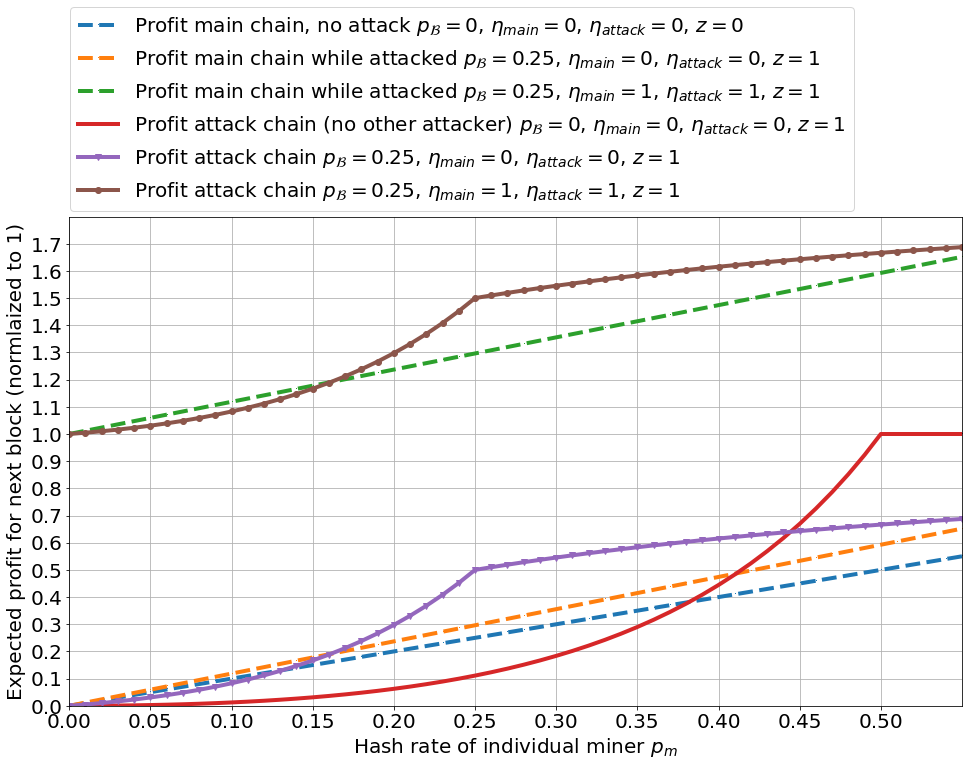

In [82]:
EV_compare_blocks()

### 4.1.2 Profitability if the attack compensates for contributed blocks (effort-related compensation)

This should approximate the expected profit, if the attack compensates every contributed block to the attack chain, regardless of the outcome of the attack. If the attack succeeds every contributed block additionally recieves $ \epsilon $ reward. 

Note that, we are still in an **infinite attack** scenario here. 
This means all blocks on the fork have to be compensated for a potentially infinte attack duration, which is unlikely in practise.
Therefore, concept wise this case more closely represents a permanent pitchfork (https://eprint.iacr.org/2018/836.pdf). 

Expected reward in number of block rewards (normalized to $ 1 $) for *one new block on the __attack__ chain* if **attack succeeds**, or otherwise **compensates for contributed blocks**:

$$
  EV_m(\texttt{fork blocks effort}) := \\
  \left( 
       \frac{ \Pr(\text{success join}) \cdot p_m}
            {p_\mathcal{B} + p_\mathcal{E} + p_m} 
       \cdot 
       ( 1 + \epsilon ) 
  \right) + \big( 
                  \eta_{fork} 
                  \cdot 
                  \epsilon
                  \cdot
                  \Pr(\text{success join})
            \big)
          + 
          \eta_{fork}
          + 
          \big( 
                  \eta_{main} 
                  \cdot
                  1-\Pr(\text{success join})
            \big)
$$

Since the compensation is effortless, you can also mine on the main chain and get your alreay
contribued attack chain blocks anyway: 

$$
  EV_m(\texttt{main blocks effort}) := \\
  \frac{ \big( 1 - \Pr(\text{success abstain})
         \big) \cdot p_m}
       {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
   + \big( \eta_{main} 
            \cdot  
            \left( 1 - \Pr(\text{success abstain})
            \right)
     \big)
   + \eta_{fork}
$$

In [67]:
#extract to .py file later
def EV_fork_blocks_effort(p_B=0,
                          p_E=0,
                          p_A=None,
                          p_V=0,
                          p_I=0,
                          p_m=0,
                          z=1,
                          epsilon=0,
                          n_fork=0,
                          n_main=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P = Pr_success_join(p_B=p_B,
                        p_E=p_E,
                        p_A=p_A,
                        p_V=p_V,
                        p_I=p_I,
                        p_m=p_m,
                        z=z)
    
    return (
                (
                   ( 
                      ( P  *  p_m ) / ( p_B + p_E + p_m ) 
                  #) * ( epsilon )
                   ) * ( 1 + epsilon )
                ) + ( n_fork * P * ( epsilon ) )
                  #+ (((1-P)*p_m)/(p_B + p_E + p_m))
                  #+ ((P_attack_chain_block * p_m)/(p_B + p_E + p_m))
                  + n_fork + (n_main * (1 - P))
            )

In [68]:
#extract to .py file later
def EV_main_blocks_effort(p_B=0,
                   p_E=0,
                   p_A=None,
                   p_V=0,
                   p_I=0,
                   p_m=0,
                   z=1,
                   n_main=0,
                   n_fork=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    assert z >= 0
    assert n_main >= 0
    
    P = Pr_success_abstain(p_B=p_B,
                           p_E=p_E,
                           p_A=p_A,
                           p_V=p_V,
                           p_I=p_I,
                           p_m=p_m,
                           z=z)
    return ( 
              ( 
                  (( 1 - P ) * p_m )
                  / ( p_A + p_V + p_I + p_m ) 
              ) + ( n_main * ( 1 - P ) ) + ( n_fork ) 
           )

In [69]:
EV_fork_blocks_effort(p_m=0.1)

0.01234567901234568

In [70]:
EV_fork_blocks(p_m=0.1)

0.01234567901234568

In [71]:
EV_fork(p_m=0.1)

0.01234567901234568

In [72]:
EV_main(p_m=0.1)

0.1

In [73]:
EV_main_blocks(p_m=0.1,n_main=1)

1.1

In [74]:
EV_fork_blocks_effort(p_m=0.1,epsilon=9,n_main=1)

1.1111111111111112

In [75]:
EV_fork_blocks_effort(p_m=0.1,epsilon=9,n_main=1,n_fork=1)

2.2222222222222223

In [76]:
EV_main_blocks(p_m=0.1,p_E=0.1,n_main=1,n_fork=1)

1.1097393689986284

In [77]:
EV_main_blocks_effort(p_m=0.1,p_E=0.1,n_main=1,n_fork=1) # it is more profitable to switch to main chain since I have the block on the attack chain for sure

2.0973936899862826

In [78]:
EV_fork_blocks_effort(p_m=0.1,p_E=0.1,epsilon=0,n_main=1,n_fork=1)

1.96875

In [79]:
EV_fork_blocks_effort(p_m=0.1,p_E=0.1,epsilon=1)

0.0625

In [80]:
EV_fork_blocks_effort(p_m=0.1,p_E=0.4,epsilon=0)

0.2

In [81]:
EV_fork_blocks_effort(p_m=0.1,p_E=0.4,epsilon=1)

0.4

In [82]:
EV_fork_blocks_effort(p_m=0.1,p_E=0.4,epsilon=1,n_fork=1) # infinite attack eventually successful

2.4

In [83]:
EV_fork_blocks_effort(p_m=0.1,p_E=0.3,epsilon=1,n_fork=1) # infinite attack not eventually successful,

1.6666666666666667

## 4.3 Account for rational victims and finite attacks

Now lets calculate the probability if the attack does not finish as soon as the attack chain takes the lead, 
but some (rational) miner (e.g., the *victim* with hashrate $p_\mathcal{V}$) keeps on mining the old main chain for some period.
Since all practicaly relevant attacks are finite, the attacker as well as the defender has a limit
of blocks that they are able/willing to sustain the attack, this is the number of stebs/blocks $ N $.
Thereby we differenciate between:

* The willingness to continue the attack even if the advantage of the main chain becomes larger is given by $ \overleftarrow{k} $. In other words, this is the number of blocks the attacker is willing to fall behind before giving up. 
* Conversely, the willingness to continue the attack even if the attack chain currently has an advantage is given by $ \overrightarrow{k} $. In other words, this is the number of blocks the defender is willing to fall behind before giving up.  
 

All variables of the the attacks are summarized as follows:

* $ N $, estimated number of steps the attack is running, i.e., can be sustained by attacker as well as defender
* $ \overleftarrow{k} $, the number of blocks the attack chain can fall behind before ending the attack attempt. If this is set to a high value, a infinite attack can be approximated quite closely. 
* $ \overrightarrow{k} $, the number of blocks the attack chain can have an advantage compared to the main chain until the attack is considered clearly won. Coversely, this can also be viewed as the number of blocks the main chain can fall behind so that the victim with hashrate $p_\mathcal{V}$ gives up. 
* $ z $, the disadvantage at the beginning of the attack, i.e., blocks behind at the start of the attack. 
* $ p_\mathcal{A} $, the *altruistic* or honest hashrate  which, switches as soon as the attack chain takes the lead. 
* $ p_\mathcal{I} $, the *indifferent* hashrate which switches as soon as a chain takes the lead. 
* $ p_\mathcal{E} $, tha rational hashrate which is assumed to work on the attack chain.
* $ p_\mathcal{V} $, the rational hashrate which is assumed to work on the main chain. 
* The hashrate of an individual rational miner $ p_m $, which is either part of $ p_\mathcal{E} $ or $ p_\mathcal{V} $.

The success/winning condition can be one of the two:
* **Win:** Be on the right half after $ N $ blocks 
* **ClearWin:** Reach a lead of $ \overrightarrow{k} $ blocks within a total of $ N $ blocks (i.e., reach a final state)

<img src="../paper/preprint/figures/markov_attack/markov_chain.png?26" width="600" height="250">

If $\overleftarrow{k} = \overrightarrow{k}$ then this can be written $\Delta_k$ and the matrix looks as follows:

In [84]:
def gen_matrix(delta_k,start): 
    
    length = delta_k * 2 + 1
    start = delta_k - start
    
    M = np.zeros(shape=(length,length))
    M_init = np.zeros(shape=(1,length))
    M_init[0][start] = 1
    
    return M,M_init

gen_matrix(3,1)

(array([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0.]]))

If  $ {\overleftarrow{k}} \neq {\overrightarrow{k}}$ then:

In [85]:
#extract to .py file later:
def Pr_success(kr=1,
               kl=6,
               N=9,
               p_B=0,
               p_A=None,
               p_E=0,
               p_V=0,
               p_I=0,
               z=0, # This is the start state, also negative values work
               pprint=False):
    
    if p_A is None:
        p_A = 1 - (p_B + p_E  + p_V + p_I)
    #assert p_A > 0
    if p_A < 0.0:
        p_A = 0.0 
    assert math.isclose(p_B + p_A + p_E  + p_V + p_I, 1)
    if kl < z:
        # catch the case where the game is already lost
        return {"Pclearwin":0.0,"Pclearlose":1.0,"Pwin":0.0,"Plose":1.0,"Pdraw":0.0}
    
    p_B = Decimal(p_B)
    p_E = Decimal(p_E)
    p_V = Decimal(p_V)
    p_I = Decimal(p_I)
    p_A = Decimal(p_A)
    
    length = kr + kl + 1
    start = kl - z
    
    # start state 
    M_init = np.zeros(shape=(1,length))
    M_init[0][start] = 1 
    
    # transition matrix of markov chain
    M = np.zeros(shape=(length,length))
    
    # final states S_delta_kr and S_-delta_kl
    M[length-1][length-1] = 1 # stay in final attack win state
    M[0][0] = 1 # stay in final main win state 
    
    # All left states and middle state, equal length
    for s in range(1,kl+1):
        M[s][s-1] = p_A + p_V + p_I
        M[s][s+1] = p_B + p_E
   
    # All right states 
    for s in range(kl+1,kr + kl):
        M[s][s-1] = p_V
        M[s][s+1] = p_B + p_E + p_A + p_I

    # convert array to matrix
    M = np.asmatrix(M)
    M_init = np.asmatrix(M_init)
    
    P = (M_init * M**int(N))
    
    Pwin = 0
    for s in range( kl+1 ,length):
        Pwin += P.item(s)
    Plose = 0
    for s in range(0, kl ):
        Plose += P.item(s)
    Pdraw = P.item( kl )
    
    if pprint:
        print(M)
        print(M_init)
        print(P)
        #print("Pwin  = ",Pwin)
        #print("Pdraw = ",Pdraw)
        #print("Plose = ",Plose)    
        #print("Total = ",Pwin + Pdraw + Plose)
    
    assert math.isclose(Pwin + Pdraw + Plose,1)
    return {"Pclearwin":P.item(length-1),"Pclearlose":P.item(0),"Pwin":Pwin,"Plose":Plose,"Pdraw":Pdraw}

In [86]:
# Samll quick test example
P = Pr_success(kr=2, 
               kl=2, 
               N=10, 
               z=1,
               p_B=0,
               p_A=None,
               p_E=0.4 + 0.1,
               p_V=0.1,
               pprint=True)
P

[[1.  0.  0.  0.  0. ]
 [0.5 0.  0.5 0.  0. ]
 [0.  0.5 0.  0.5 0. ]
 [0.  0.  0.1 0.  0.9]
 [0.  0.  0.  0.  1. ]]
[[0. 1. 0. 0. 0.]]
[[0.677125 0.002025 0.       0.002025 0.318825]]


{'Pclearwin': 0.318825,
 'Pclearlose': 0.677125,
 'Pwin': 0.32085,
 'Plose': 0.67915,
 'Pdraw': 0.0}

Now compare the old calculation with `catch_up()` to the new one.
Therefore, we approximate the infinite attack by executing the finite one for a long time
and configure it in a way that it stops as soon as the attack chain takes the lead (see below).

Keep in mind, in this calculation the miner $ p_m $ in question does **not** join the attack but stays on the main chain! Therefore, he has to take the side of a victim in this case. 
Although, for $ \overrightarrow{k}=1 $, $ p_\mathcal{V} $ can be modelled as part of $ p_\mathcal{A} $. 

In [87]:
Pr_success_abstain(p_E=0.4,
                   z=1)

0.44444444444444453

In [88]:
catch_up(0.4,z=1)

0.44444444444444453

In [89]:
P = Pr_success(kr=1, # immediate win once the attack chain takes the lead
               kl=2000, # attack chain can fall behind for a very long period
               N=3000, # the attack runs for a long time
               z=1,
               p_B=0,
               p_A=None,
               p_E=0.4,
               p_V=0.0 + 0.16,  # p_V + p_m but p_m is irrelevant in this configuraiton as kr = 1
               pprint=True)
P

[[1.  0.  0.  ... 0.  0.  0. ]
 [0.6 0.  0.4 ... 0.  0.  0. ]
 [0.  0.6 0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.4 0. ]
 [0.  0.  0.  ... 0.6 0.  0.4]
 [0.  0.  0.  ... 0.  0.  1. ]]
[[0. 0. 0. ... 1. 0. 0.]]
[[1.12709104e-168 1.36429150e-168 0.00000000e+000 ... 9.89550969e-032
  0.00000000e+000 4.44444444e-001]]


{'Pclearwin': 0.44444444444444453,
 'Pclearlose': 1.1270910365786654e-168,
 'Pwin': 0.44444444444444453,
 'Plose': 0.5555555555555343,
 'Pdraw': 0.0}

In [90]:
assert math.isclose(P["Pwin"],catch_up(0.4,z=1))

The following small Markov chain can be calculated by hand. 

In [91]:
P = Pr_success(kr=1, # immediate win once the attack chain takes the lead
               kl=2, 
               N=2, 
               z=1,
               p_B=0,
               p_A=None,
               p_E=0.4,
               p_V=0.0,
               pprint=True)
P

[[1.  0.  0.  0. ]
 [0.6 0.  0.4 0. ]
 [0.  0.6 0.  0.4]
 [0.  0.  0.  1. ]]
[[0. 1. 0. 0.]]
[[0.6  0.24 0.   0.16]]


{'Pclearwin': 0.16000000000000003,
 'Pclearlose': 0.6,
 'Pwin': 0.16000000000000003,
 'Plose': 0.84,
 'Pdraw': 0.0}

In [92]:
clear_win = 0.4 * 0.4
clear_win # which is the same as win in this case

0.16000000000000003

In [93]:
clear_lose = 0.6
clear_lose

0.6

In [94]:
lose = clear_lose + 0.4 * 0.6
lose

0.84

Now we want to see how fast, in terms of $ N $, the probability of success approaches the probability of success in the infinte catch-up case: 

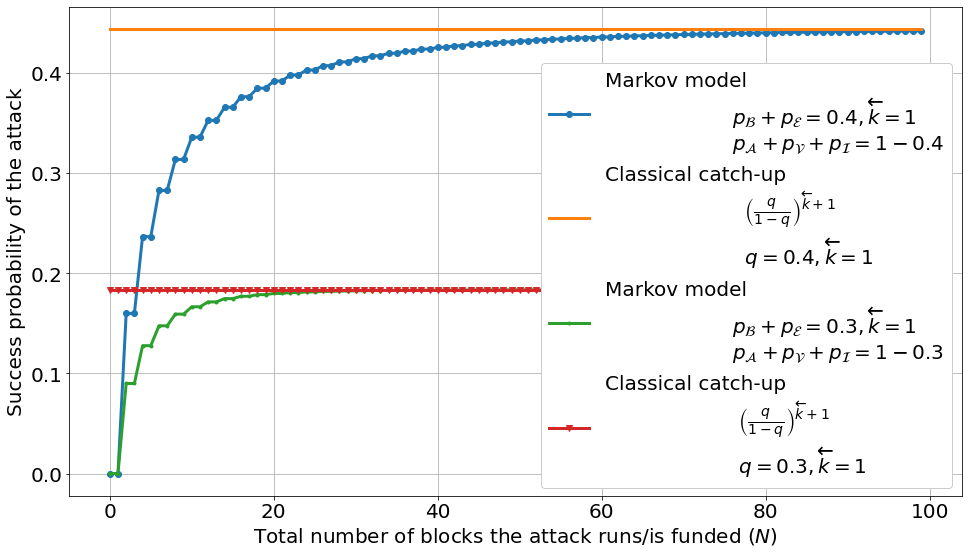

In [95]:
def markov_attack_vs_catch_up():
    p_B = 0
    p_E = 0
    p_A = None
    p_V = 0
    p_I = 0
    z = 1
    epsilon = 0
    N = [ n for n in np.arange(0,100,1) ]
    
    fig, ax = plt.subplots(figsize=(16, 9)) 
    # https://matplotlib.org/api/markers_api.html
    marker = itertools.cycle((',','v', '+', 's','.', 'o', '*','1','D','x','^'))
    
    # main chain without attack
    P_markov = [ Pr_success(kr=1, # immediate win once the attack chain takes the lead
                            kl=n, 
                            N=n,  
                            z=1,
                            p_B=0,
                            p_A=None,
                            p_E=0.4,
                            p_V=0.0)["Pwin"] for n in N ]
    
    plt.plot(N, 
             P_markov, 
             marker='o', 
             linewidth=3, 
             label="""Markov model
                    $ p_\\mathcal{B} + p_\\mathcal{E} = 0.4, \\overleftarrow{k}=1 $
                    $ p_\\mathcal{A} + p_\\mathcal{V} + p_\\mathcal{I} = 1-0.4 $"""
            )
    
    # attack chain
    P_catchup = [ catch_up(q=0.4,
                           z=1) for n in N ]
 
    plt.plot(N, 
             P_catchup, 
             marker=',', 
             linewidth=3, 
             label="""Classical catch-up
                      $ \\left(\\frac{q}{1-q}\\right)^{\\overleftarrow{k}+1} $
                      $ q = 0.4, \\overleftarrow{k}=1 $"""
            )
    
    
    P_markov = [ Pr_success(kr=1,   # immediate win once the attack chain takes the lead
                            kl=n,   
                            N=n,    
                            z=1,
                            p_B=0,
                            p_A=None,
                            p_E=0.3,
                            p_V=0.0)["Pwin"] for n in N ]
    
    plt.plot(N, 
             P_markov, 
             marker='.', 
             linewidth=3, 
             label="""Markov model
                    $ p_\\mathcal{B} + p_\\mathcal{E} = 0.3, \\overleftarrow{k}=1 $
                    $ p_\\mathcal{A} + p_\\mathcal{V} + p_\\mathcal{I} = 1-0.3 $"""
            )
    
    
    P_catchup = [ catch_up(q=0.3,
                           z=1) for n in N ]
 
    plt.plot(N, 
             P_catchup, 
             marker='v', 
             linewidth=3, 
             label="""Classical catch-up 
                     $ \\left(\\frac{q}{1-q}\\right)^{\\overleftarrow{k}+1} $
                     $ q = 0.3, \\overleftarrow{k}=1 $"""
            )
    
    # tidy up the figure
    ax.grid(True)
    #ax.legend(loc='center right', bbox_to_anchor=(0.8, 0.57))
    ax.legend(loc='center right', 
              bbox_to_anchor=(1.0, 0.45), # location of the legend
              framealpha=1.0)              # turn off transparency of legend
    #ax.set_title("Attack success probability")
    ax.set_xlabel("Total number of blocks the attack runs/is funded ($N$)")
    ax.set_ylabel("Success probability of the attack")
    
    #ax.set_ylim([0.0, 1.1])
    #ax.set_xlim([0,1.0]) 
    #plt.yticks(np.arange(0.0, 1.1, step=0.1))
    #plt.xticks(np.arange(0.0, 1.1, step=0.1))
    
    #plt.yscale('log')
    plt.rcParams.update({'font.size': 20})
    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.savefig("../paper/preprint/figures/markov_vs_catchup.png", dpi=200) 
    plt.show()

markov_attack_vs_catch_up()

As we see the probability *Pwin* as well as *Pclearwin* are the same, as the attack is declared as clear win as soon as it is in the lead. 
Moreover the propability matches the expected output of the infinite case very close as $ N $ increases. 

Now we calculate the attack success probability under more realistic conditions. 
* Shorter attack duration $ N $
* Attacker gives up when the main chain has and advantage of $ 6 $ blocks 

As we see compared to the infinte catch-up, this finite attack is of course less likely to succeed. Even more so if there is a rational victim $ p_\mathcal{V} $ which will mine againt the attack even if it has taken the lead. 

In [96]:
catch_up(0.4,z=1)

0.44444444444444453

In [97]:
Pr_success(kr=1,
           kl=6,
           N=14,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.4,
           p_V=0,
           pprint=True)

[[1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.6 0.  0.4 0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.4 0.  0.  0.  0. ]
 [0.  0.  0.6 0.  0.4 0.  0.  0. ]
 [0.  0.  0.  0.6 0.  0.4 0.  0. ]
 [0.  0.  0.  0.  0.6 0.  0.4 0. ]
 [0.  0.  0.  0.  0.  0.6 0.  0.4]
 [0.  0.  0.  0.  0.  0.  0.  1. ]]
[[0. 0. 0. 0. 0. 1. 0. 0.]]
[[0.3841351  0.0751264  0.         0.11365276 0.         0.06150458
  0.         0.36558116]]


{'Pclearwin': 0.36558115766272004,
 'Pclearlose': 0.38413509672959995,
 'Pwin': 0.36558115766272004,
 'Plose': 0.6344188423372799,
 'Pdraw': 0.0}

In [98]:
%%time
Pr_success(kr=3,
           kl=6,
           N=14,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.4,
           p_V=0.2,
           pprint=True)

[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.6 0.  0.4 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.4 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.6 0.  0.4 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.6 0.  0.4 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.6 0.  0.4 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.6 0.  0.4 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.2 0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.39213515 0.08161626 0.         0.12697901 0.         0.07473231
  0.         0.02218946 0.         0.30234782]]
CPU times: user 2.44 ms, sys: 0 ns, total: 2.44 ms
Wall time: 2.41 ms


{'Pclearwin': 0.3023478194176,
 'Pclearlose': 0.3921351450623994,
 'Pwin': 0.32453728141311994,
 'Plose': 0.675462718586879,
 'Pdraw': 0.0}

In [99]:
%%time 
Pr_success(kr=3,
           kl=6,
           N=14,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.4,
           p_V=0.2,
           pprint=True)

[[1.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.6 0.  0.4 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.6 0.  0.4 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.6 0.  0.4 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.6 0.  0.4 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.6 0.  0.4 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.6 0.  0.4 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.2 0.  0.8 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.8]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.39213515 0.08161626 0.         0.12697901 0.         0.07473231
  0.         0.02218946 0.         0.30234782]]
CPU times: user 4.16 ms, sys: 59 µs, total: 4.22 ms
Wall time: 3.63 ms


{'Pclearwin': 0.3023478194176,
 'Pclearlose': 0.3921351450623994,
 'Pwin': 0.32453728141311994,
 'Plose': 0.675462718586879,
 'Pdraw': 0.0}

**Other examples:**

First, lets look at the $ 38.2\% $ bound in this case. As we see, the larger $ \overleftarrow{k} $ and $ N $, get the probability of success increases above $ 38.2 \%$. This is not the case $ p_\mathcal{E} < 38.2\%$.

In [100]:
%%time
Pr_success(kr=1,
           kl=64,
           N=150,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.382,
           p_V=0,
           pprint=False)

CPU times: user 0 ns, sys: 9.63 ms, total: 9.63 ms
Wall time: 1.82 ms


{'Pclearwin': 0.3819828881279193,
 'Pclearlose': 0.01042211433693812,
 'Pwin': 0.3819828881279193,
 'Plose': 0.6180171118720801,
 'Pdraw': 0.0}

In [101]:
%%time
Pr_success(kr=1,
           kl=2000,
           N=3000,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.382,
           p_V=0,
           pprint=False)

CPU times: user 31 s, sys: 11.8 s, total: 42.8 s
Wall time: 6.28 s


{'Pclearwin': 0.3820760151234277,
 'Pclearlose': 1.3927144537146563e-146,
 'Pwin': 0.3820760151234277,
 'Plose': 0.6179239848765599,
 'Pdraw': 0.0}

In [102]:
%%time
Pr_success(kr=1,
           kl=2000,
           N=3000,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.381,
           p_V=0,
           pprint=False)

CPU times: user 31 s, sys: 8.12 s, total: 39.1 s
Wall time: 5.51 s


{'Pclearwin': 0.3788511878818565,
 'Pclearlose': 2.1380742204146912e-145,
 'Pwin': 0.3788511878818565,
 'Plose': 0.6211488121181163,
 'Pdraw': 0.0}

Now lets try how exact we can approach this bound:

In [103]:
from scipy.constants import golden as phi
1/phi**2

0.38196601125010515

In [104]:
%%time
Pr_success(kr=1,
           kl=2000,
           N=3000,
           z=1,
           p_B=0,
           p_A=None,
           p_E=1/phi**2,
           p_V=0,
           pprint=False)

CPU times: user 31 s, sys: 5.08 s, total: 36.1 s
Wall time: 4.86 s


{'Pclearwin': 0.3819660112501054,
 'Pclearlose': 1.5284426709225952e-146,
 'Pwin': 0.3819660112501054,
 'Plose': 0.6180339887499858,
 'Pdraw': 0.0}


**Just some more test cases:** 

In [105]:
catch_up(0.4,z=0)

0.6666666666666667

In [106]:
%%time
P = Pr_success(kr=1, # immediate win once the attack chain takes the lead
               kl=2000, # attack chain can fall behind for a very long period
               N=3000, # the attack runs for a long time
               z=0, # start at the same hight
               p_B=0,
               p_A=None,
               p_E=0.4,
               p_V=0.0,  
               pprint=False)
P

CPU times: user 31.2 s, sys: 4.97 s, total: 36.1 s
Wall time: 4.94 s


{'Pclearwin': 0.6666666666666669,
 'Pclearlose': 6.762546219472007e-169,
 'Pwin': 0.6666666666666669,
 'Plose': 0.3333333333333205,
 'Pdraw': 2.47635047578567e-32}

In [107]:
assert math.isclose(P["Pwin"],catch_up(0.4,z=0))

In [108]:
catch_up(0.3,z=1)

0.18367346938775514

In [109]:
Pr_success_abstain(p_E=0.3,
                   p_m=0.40,
                   z=1)

0.18367346938775514

In [110]:
assert Pr_success_abstain(p_E=0.3,
                          p_m=0.40,
                          z=1),catch_up(0.3,z=1)

In [111]:
%%time 
P = Pr_success(kr=1, # immediate win once the attack chain takes the lead
               kl=100, # attack chain can fall behind for a very long period
               N=600, # the attack runs for a long time
               z=1,
               p_B=0,
               p_A=None,
               p_E=0.3,
               p_V=0.0 + 0.4,  # p_V + p_m
               pprint=False)
P

CPU times: user 36.7 ms, sys: 73.9 ms, total: 111 ms
Wall time: 17.1 ms


{'Pclearwin': 0.18367346938775514,
 'Pclearlose': 0.8163265304698074,
 'Pwin': 0.18367346938775514,
 'Plose': 0.8163265306122586,
 'Pdraw': 0.0}

In [112]:
assert math.isclose(P["Pwin"],Pr_success_abstain(p_E=0.3,p_m=0.40))

### 4.3.1 Profitability main chain using the Markov chain model to derive the success probabilities 
Now, lets plug the Markov chain based probability calculation into the reward calcualation which also accounts for already mined blocks. 

Expected profit in number of block rewards (normalized to $ 1 $) for *one new block on the __main__ chain* if **attack fails**: 

$$
  EV_m(\texttt{main markov blocks}) := \\
  \frac{ \big( 1 - \Pr(\text{success abstain})
         \big) \cdot p_m}
       {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
   + \big( \eta_{main} 
            \cdot  
            \left( 1 - \Pr(\text{success abstain})
            \right)
     \big)
     + \left( \Pr(\text{success abstain}) \cdot \eta_{fork} \cdot (\epsilon+1) \right)
$$

Despite changing the probability calculation method, two things 
have to be noted here: 
* Here either $ p_m $ has to be modelled as part of $ p_\mathcal{V} $ or $ p_\mathcal{I} $
* Are we interested in the *clear win* (`Pclearwin`) proability, or the *win* (`win`) probability?

In [113]:
#extract to .py file later:
def EV_main_markov_blocks(p_B=0,
                          p_E=0,
                          p_A=None,
                          p_V=0,
                          p_I=0,
                          p_m=0,
                          z=1,
                          n_main=0,
                          kr=1,
                          kl=6,
                          N=6,
                          Pm_mode="V",
                          Prslt="Pwin",
                          n_fork=0,
                          epsilon=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    assert z >= 0
    assert n_main >= 0
    
    # either p_m is part of p_V, or of p_I
    assert (Pm_mode == "V" or Pm_mode == "I")
    if Pm_mode == "V":
        P = Pr_success(kr=kr, 
                       kl=kl, 
                       N=N,
                       z=z,
                       p_B=p_B,
                       p_A=p_A, 
                       p_I=p_I,
                       p_E=p_E,
                       p_V=p_V + p_m)[Prslt] # here it is part of p_V
    elif Pm_mode == "I":
        P = Pr_success(kr=kr, 
                       kl=kl, 
                       N=N,
                       z=z,
                       p_B=p_B,
                       p_A=p_A, 
                       p_I=p_I + p_m, # here it is part of p_I
                       p_E=p_E,
                       p_V=p_V)[Prslt] 

    assert N > 0 # because if N == 0 then the attack is over
    return ( 
              ( 
                  (( 1 - P ) * p_m )
                  / ( p_A + p_V + p_I + p_m ) 
              ) + ( n_main * ( 1 - P ) ) + ( P * n_fork * (epsilon+1) )
           )

In [114]:
assert EV_main(p_m=0.1) == EV_main_blocks(p_m=0.1)
assert EV_main(p_m=0.1) < EV_main_blocks(p_m=0.1,n_main=1)

assert EV_main_markov_blocks(p_m=0.1) == EV_main_blocks(p_m=0.1)
assert EV_main_markov_blocks(p_m=0.1,n_main=1) == EV_main_blocks(p_m=0.1,n_main=1)

In [115]:
EV_main_blocks(p_m=0.1)

0.1

In [116]:
EV_main_blocks(p_m=0.1,n_main=1)

1.1

In [117]:
EV_main_markov_blocks(p_m=0.1)

0.1

In [118]:
EV_main_markov_blocks(p_m=0.1,n_main=1)

1.1

### 4.3.1 Profitability fork chain using the Markov chain model to derive the success probabilities 

Expected profit in number of block rewards (normalized to $ 1 $) for *one new block on the __attack__ chain* if **attack succeeds**. This assumes that the bribe $ \epsilon $ is payed out on a per block basis, if there is any bribe ($ \epsilon > 0 $):

$$
  EV_m(\texttt{fork markov blocks}) := \\
  \left( 
       \frac{ \Pr(\text{success join}) \cdot p_m}
            {p_\mathcal{B} + p_\mathcal{E} + p_m} 
       \cdot 
       ( \epsilon + 1 )
  \right) + \big( 
                  \eta_{fork} 
                  \cdot 
                  ( \epsilon + 1 ) 
                  \cdot
                  \Pr(\text{success join})
            \big)
               + \big( 
                  \eta_{main} 
                  \cdot
                  ( 1 - \Pr(\text{success join}))
            \big)
$$

Again here we have to ask ourselfs: 
* Are we interested in the *clear win* (`Pclearwin`) proability, or the *win* (`win`) probability?


In [119]:
#extract to .py file later:
def EV_fork_markov_blocks(p_B=0,
                          p_E=0,
                          p_A=None,
                          p_V=0,
                          p_I=0,
                          p_m=0,
                          z=1,
                          epsilon=0,
                          n_fork=0,
                          kr=1,
                          kl=6,
                          N=6,
                          Prslt="Pwin",
                          n_main=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    

    P = Pr_success(kr=kr, 
                       kl=kl, 
                       N=N,
                       z=z,
                       p_B=p_B,
                       p_A=p_A,
                       p_I=p_I,
                       p_E=p_E + p_m,
                       p_V=p_V)[Prslt]
        
    assert N > 0 # because if N == 0 then the attack is over 
    return (
                (
                   ( 
                      ( P  *  p_m ) / ( p_B + p_E + p_m ) 
                   ) * ( epsilon + 1 )
                ) + ( n_fork * P * ( epsilon + 1 ) ) + ( n_main * ( 1 - P))
            )

In [120]:
assert EV_fork(p_m=0.1) == EV_fork_blocks(p_m=0.1)
assert EV_fork(p_m=0.1) < EV_fork_blocks(p_m=0.1,n_fork=1)

assert EV_fork_markov_blocks(p_m=0.1,
                     n_fork=0,
                     kr=1,
                     kl=100,
                     N=101) == EV_fork_blocks(p_m=0.1)
assert EV_fork_markov_blocks(p_m=0.1,
                     n_fork=1,
                     kr=1,
                     kl=100,
                     N=101) == EV_fork_blocks(p_m=0.1,n_fork=1)
assert math.isclose(EV_fork_markov_blocks(p_m=0.1,
                       n_fork=1,
                       kr=100,
                       kl=100,
                       N=101),EV_fork_blocks(p_m=0.1,n_fork=1))

In [121]:
EV_fork_blocks(p_m=0.25,n_fork=1)

0.2222222222222222

In [122]:
EV_fork_markov_blocks(p_m=0.25,
                      n_fork=1,
                      kr=100,
                      kl=100,
                      N=101)

0.22222222063427843

In [123]:
EV_main_markov_blocks(p_m=0.25,
                      n_main=1,
                      kr=1,
                      kl=8,
                      N=8)

1.25

In [124]:
EV_fork_markov_blocks(p_m=0.25,
                      n_fork=1,
                      kr=1,
                      kl=8,
                      N=8)

0.20538330078125

In [125]:
EV_main_markov_blocks(p_m=0.25,
                      p_E=0.1,
                      n_main=1,
                      n_fork=1,
                      kr=1,
                      kl=8,
                      N=8)

1.27435915

In [126]:
EV_fork_markov_blocks(p_m=0.25,
                      p_E=0.1,
                      n_main=1,
                      n_fork=1,
                      kr=1,
                      kl=8,
                      N=8)

1.164379679296875

In [127]:
EV_fork_markov_blocks(p_m=0.25,
                      p_E=0.1,
                      n_main=0,
                      n_fork=1,
                      kr=1,
                      kl=8,
                      N=8)

0.3945112303124999

### Detour: What is the probability to mine at least one block on the attack chain during the duration of the attack

To calculate the probability to mine at least one block for the remaining attack. We describe two ways to approach this. The first ist using the estimated remaining time the attack will run, the second the remaining blocks the attack will run. 

#### Probability that at least one block is found by $ m $ during the remaining duration of the attack (in terms of time)

What is the probability that **at least one block** is found by $ p_m $ in the attack chain during the remaining duration of the attack?

Assuming that the time between blocks is exponentially distribued and that the difficulty and overall hashrate is constant. 
The mean block interval, i.e., the expected value $E(X)$ is $ 10\cdot 60 $ seconds in Bitcoin.
$$
\begin{align}
E_{BTC}(X) &:= 600\\
\lambda &= \frac{1}{E_{BTC}(X)} = \frac{1}{600}\\
\Pr(X < x) &= 
        \begin{cases}
            1 - \exp(-\lambda x)       & x  \geq 0, \\
            0                          & x     < 0
        \end{cases} \\
\Pr(X \geq x) &= exp(-\lambda x) = e^{-\lambda \cdot x}
\end{align}
$$

Let $ x $ denote the length of the attack, in blocks times the mean block interval. 
For example if the remaining duration of the attack is $ 6 $ blocks $ x := 600 \cdot 6 $. 
Let $ p_m $ denote the fraction of the hashrate in question which should find a block within $ x $ For example let $ p_m := 0.5 $. 

$$
\begin{align}
x &:= 600\cdot6 = 3600\\
p_m &:= 0.5 \\ 
E_{m}(X) &= E_{BTC}(X) \cdot \frac{1}{p_{m}} = E_{BTC}(X) \cdot \frac{1}{0.5} \\ 
\lambda &= \frac{1}{E_{m}(X)} = \frac{1}{1200}\\
\Pr(\text{find block in t}) = \Pr(X < x) &= 1 - e^{-\lambda \cdot x} \\
\end{align}
$$

In [128]:
def Pr_find_block_in_t(p_m=0.5,x=6*(10*60),EX=10*60):
    """ Calculate the probability to mine a block given the hashrate p_m, within time x 
    time, for the given expected value (mean block intnerval) between blocks E(X).
    
    p_m                    Individual hashrate
    x                      Time to mine at least one block 
    EX                     Mean block interval of the cryptocurrency, i.e., the expected value E(X)
    """
    assert p_m <= 1
    EX_m = EX*(1/p_m)
    vlambda = 1/EX_m    
    P = 1 - math.e**( -vlambda * x) 
    return P

In [129]:
Pr_find_block_in_t(p_m=1,x=600)

0.6321205588285577

In [130]:
Pr_find_block_in_t(p_m=0.5,x=600)

0.3934693402873666

In [131]:
def Pr_find_block_in_t_fork(p_m,p_fork,duration=6,EX=10*60):
    """ Calculate the probability to mine a block given the hashrate p_m and overall hashrate p_fork, 
    within the remaining time, for the given expected value (mean block intnerval) between blocks E(X).
    
    p_m                    Individual hashrate
    p_fork                 Fraction of the total hashrate that will mine on a given fork
    duration               Remaining duration of the fork/attack in blocks                     
    EX                     Mean block interval of the cryptocurrency before fork, i.e., the expected value E(X)
    """
    assert p_m <= p_fork and p_fork <= 1

    EX_m = EX*(1/p_m)
    vlambda = 1/EX_m
    
    x = duration * EX*(1/p_fork)
    
    P = 1 - math.e**( -vlambda * x) 
    return P

In [132]:
Pr_find_block_in_t_fork(p_m=0.1,p_fork=0.5,duration=1,EX=600)

0.18126924692201807

In [133]:
Pr_find_block_in_t_fork(p_m=0.1,p_fork=0.6,duration=6,EX=600)

0.6321205588285577

#### Probability that *at least* M blocks are found by $ m $ within N total blocks
To calculate the probability to mine **at least** $ M $ blocks within $ N $ total blocks with hashrate $ q $, we reuse the probability to mine $ n=\{1,2,\dots,M\} $ blocks while others mine $ N-m $ blocks iteratively and sum up the results.  
$$
\begin{align}
\Pr(\text{find M blocks in N}) &= \sum_{n=1}^{M} P(n) \\ 
     &= \sum_{n=1}^{M} \binom{n+(N-n)}{n} \cdot p^{N-n} \cdot q^n 
\end{align}
$$

In [134]:
def Pr_find_M_blocks_in_N(M=1,
                          N=6,
                          p_m=0,
                          p_fork=None):
    if M <= 0:
        assert False,"M must be > 0"
    if M > N:
        assert False,"M must be <= N"
    # Bring total hashrate into proportion for the fork 
    if p_fork is None: 
        q = p_m # due to rounding this is more precise 
    else:
        q = p_m * (1/p_fork)
    p = 1 - q
    
    P = 0
    for n in range(M,N+1):
        #print(m)
        P += scipy.special.binom(n+(N-n),n)*(p**(N-n))*(q**n)
    if P > 1: # due to rounding issues
        return 1
    return P

Check if the probability is exaclty the hashrate if calculate for one block only:

In [135]:
assert Pr_find_M_blocks_in_N(M=1,N=1,p_m=0.1,p_fork=None) == 0.1
Pr_find_M_blocks_in_N(M=1,N=1,p_m=0.1,p_fork=None)

0.1

Check if the probability is exaclty 0.2 if the total hashrate on fork is 0.5 :

In [136]:
assert Pr_find_M_blocks_in_N(M=1,N=1,p_m=0.1,p_fork=0.5) == 0.2
Pr_find_M_blocks_in_N(M=1,N=1,p_m=0.1,p_fork=0.5)

0.2

In [137]:
Pr_find_M_blocks_in_N(M=1,N=2,p_m=0.1,p_fork=0.5)

0.3600000000000001

### 4.3.1 Profitability of main and fork chain with compensations of already contribued blocks to the attack/fork using the Markov chain model to derive the success probabilities (effort-related compensation)

Expected profit in number of block rewards (normalized to $ 1 $) for *one new block on the __attack__ chain* if **attack succeeds** and already contribued blocks are **compensated** regardless of the attack outcome. 
This assumes that the bribe $ \epsilon $ is payed out on a per block basis, if there is any bribe ($ \epsilon > 0 $).

In this case I have the following possibilities, which are reflected in the formulars below:
* If the attack is successful, and I mine the next attack block, I get $ 1 + \epsilon $ for it.
* If the attack fails, and I mine the next attack block, I get $ 1 $ for it. 
* In any case I get $ 1 $ for every already contributed block to the attack cahin
* If the attack succeeds I get an additional $ \epsilon $ for all already contributed blocks to the attack chain.
* If the attack is unsuccessful, I get my blocks on the main chain with that probability

$$
  EV_m(\texttt{fork markov blocks effort}) :=\\ 
       \frac{ 
              \Pr(\text{success join}) \cdot p_m
             }
            {p_\mathcal{B} + p_\mathcal{E} + p_m} 
       \cdot 
       ( 1 + \epsilon ) 
          +\\  
          \frac{
                (1 - \Pr(\text{success join})) \cdot p_m}
               {p_\mathcal{B} + p_\mathcal{E} + p_m}
          +\\
          \eta_{fork}
          +\\
            \big( 
                  \eta_{fork} 
                  \cdot 
                  \epsilon 
                  \cdot
                  \Pr(\text{success join})
            \big)
          +\\
          \big( 
                  \eta_{main} 
                  \cdot 
                  \left( 1 - \Pr(\text{success join}) \right)
            \big)
$$

For the main chain the situation is almost the same as before, despite I get the contributed
blocks to the attack chain in any case. 

$$
  EV_m(\texttt{main markov blocks effort}) := \\
  \frac{ \big( 1 - \Pr(\text{success abstain})
         \big) \cdot p_m}
       {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
   + \big( \eta_{main} 
            \cdot  
            \left( 1 - \Pr(\text{success abstain})
            \right)
     \big)
     + \eta_{fork} + \left( \eta_{fork} \cdot \epsilon \cdot \Pr(\text{success abstain}) \right) 
$$

Again here we have to ask ourselfs: 
* Are we interested in the *clear win* (`Pclearwin`) proability, or the *win* (`win`) probability?

In [138]:
#extract to .py file later:
def EV_fork_markov_blocks_effort(p_B=0,
                                 p_E=0,
                                 p_A=None,
                                 p_V=0,
                                 p_I=0,
                                 p_m=0,
                                 z=1, # This is the current state in terms of blocks behind, could also be negative i.e., represent a lead
                                 epsilon=0,
                                 n_fork=0,
                                 kr=1,
                                 kl=6,
                                 N=6, # Remaining duration of attack 
                                 Prslt="Pwin",
                                 duration=None, # this is the remaining duration, often this will just be N
                                 n_main=0): 
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P = Pr_success(kr=kr, 
                       kl=kl, 
                       N=N,
                       z=z,
                       p_B=p_B,
                       p_A=p_A,
                       p_I=p_I,
                       p_E=p_E + p_m,
                       p_V=p_V)[Prslt]

    
    # depricated version which assume 1.0 here:
    #if duration is None: 
    #    P_block = 1.0
    
    if duration is None:
        # If not explicit duration was given
        # it is assumed the duration is N
        duration = N
    
    # Depricate version which used time here:
    #P_block = Pr_find_block_in_t_fork(p_m=p_m,
    #                                  p_fork=(p_B+p_E+p_m),
    #                                  duration=duration,
    #                                  EX=10*60)

    # Depricate version with used M blocks here:
    #P_block = Pr_find_M_blocks_in_N(M=1,
    #                                N=N,
    #                                p_m=p_m,
    #                                p_fork=(p_B+p_E+p_m))
    
    assert N > 0 # the attack is technically over
    EV = (
                (
                   ( 
                     # ( P_block * P  *  p_m ) / ( p_B + p_E + p_m ) 
                       ( P  *  p_m ) / ( p_B + p_E + p_m )
                   ) * ( 1 + epsilon )
                ) #+ ( ( P_block * (1-P) * p_m )/ (p_B + p_E + p_m) ) 
                  + ( ( (1-P) * p_m )/ (p_B + p_E + p_m) )
                  + n_fork
                  + ( n_fork * P * epsilon )
                  + ( n_main * ( 1 - P))
             )
    return EV

In [139]:
#extract to .py file later:
def EV_main_markov_blocks_effort(p_B=0,
                          p_E=0,
                          p_A=None,
                          p_V=0,
                          p_I=0,
                          p_m=0,
                          z=1,
                          n_main=0,
                          kr=1,
                          kl=6,
                          N=6,
                          Pm_mode="V",
                          Prslt="Pwin",
                          epsilon=0,
                          n_fork=0):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m ) 
    if p_A < 0:
        p_A = 0 
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    assert z >= 0
    assert n_main >= 0
    
    # either p_m is part of p_V, or of p_I
    assert (Pm_mode == "V" or Pm_mode == "I")
    if Pm_mode == "V":
        P = Pr_success(kr=kr, 
                       kl=kl, 
                       N=N,
                       z=z,
                       p_B=p_B,
                       p_A=p_A, 
                       p_I=p_I,
                       p_E=p_E,
                       p_V=p_V + p_m)[Prslt] # here it is part of p_V
    elif Pm_mode == "I":
        P = Pr_success(kr=kr, 
                       kl=kl, 
                       N=N,
                       z=z,
                       p_B=p_B,
                       p_A=p_A, 
                       p_I=p_I + p_m, # here it is part of p_I
                       p_E=p_E,
                       p_V=p_V)[Prslt] 

    assert N > 0 # because if N == 0 then the attack is over
    return ( 
              ( 
                  (( 1 - P ) * p_m )
                  / ( p_A + p_V + p_I + p_m ) 
              ) + ( n_main * ( 1 - P ) ) + ( n_fork ) + ( n_fork * epsilon * P  )
           )

Lets check the results for plausability. 
If every contributed block to the attack chain is compensated 1:1, 
I should eventually get an EV of 1, if the attack lasts long enough i.e., has a high $ N $ (i.e., duration), even with a small hashrate.

In [140]:
EV = EV_fork_markov_blocks_effort(p_B=0,
                             p_E=0,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=100,
                             N=100)
assert EV == 1.0
EV

1.0

If I am the only miner I should certainly 
get one block if only one block is there to be mined

In [141]:
EV = EV_fork_markov_blocks_effort(p_E=0,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=2,
                             N=1)
assert EV == 1.0
EV

1.0

The corner case $ N = 0 $ is not captured, yet as the attack is techncially already over then. 

In [142]:
try:
    EV_fork_markov_blocks_effort(p_E=0,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=2,
                             N=0)
    assert False
except AssertionError:
    assert True

Since all contributed blocks are rewarded with 1, I should get an EV proportional to my hashrate on the attack chain. Even if the attack is unlikely to succeed and otherwise does not provide any additional bribes.


In [143]:
EV = EV_fork_markov_blocks_effort(p_E=0.1,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=2,
                             N=1)
assert EV == 0.5
EV

0.5

If the attack has a chance (even a low one) to win but does not provide any bribe, I should get the same EV. 

In [144]:
EV = EV_fork_markov_blocks_effort(p_E=0.1,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=2,
                             N=2)
assert EV == 0.5
EV

0.5

In [145]:
EV = EV_fork_markov_blocks_effort(p_E=0.3,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=100,
                             N=10)
assert EV == 0.25
EV

0.25

In [146]:
EV = EV_fork_markov_blocks_effort(p_E=0.3,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=0,
                             n_fork=0,
                             kr=1,
                             kl=100,
                             N=100)
assert EV == 0.25
EV

0.25

If the attack has a change and does provide a bribe, my EV is slightly higher. 

In [147]:
EV_fork_markov_blocks_effort(p_E=0.2,
                             p_V=0.4,
                             p_m=0.2,
                             z=1,
                             epsilon=1,
                             n_fork=0,
                             kr=2,
                             kl=2,
                             N=2)

0.5800000000000001

In [148]:
EV_fork_markov_blocks_effort(p_E=0.2,
                             p_V=0.4,
                             p_m=0.2,
                             z=0,
                             epsilon=1,
                             n_fork=0,
                             kr=2,
                             kl=2,
                             N=3)

0.7000000000000001

In [149]:
EV_fork_markov_blocks_effort(p_E=0.3,
                             p_V=0.3,
                             p_m=0.3,
                             z=0,
                             epsilon=1,
                             n_fork=0,
                             kr=2,
                             kl=2,
                             N=6)

0.8352440000000001

In [150]:
EV_fork_markov_blocks(p_E=0.1,
                      p_m=0.1,
                      z=0,
                      kr=1,
                      kl=2,
                      N=1)

0.10000000000000002

In [151]:
EV_fork_markov_blocks_effort(p_E=0,
                             p_V=0,
                             p_m=0.1,
                             z=1,
                             epsilon=1,
                             n_fork=0,
                             kr=1,
                             kl=100,
                             N=101)

1.0123456790123457

In [152]:
EV_main_markov_blocks(p_E=0.3,
                      p_V=0,
                      p_m=0.1,
                      z=1,
                      n_main=0,
                      kr=1,
                      kl=100,
                      N=10)

0.1190478226

### Corner case: $ N := 0 $

If $ N := 0 $ this means there is no attack that can be funded. 
So in the simplest model we ignore this corner case as there is no attack that could be funded. 
Hence the EV depends on the already mined blocks and the current state of the chain race. If $ z < 0 $, this means the attack is in the lead and has won. If $ z > 0 $, the attack chain is behind and has lost and only already mined blocks are paid. In this case the decision wheather, or not to continue mining on the fork branch depends on the already contributed blocks. 
If the attack is at state $ z = 0 $, then it is a draw but no more rewards/bribes can be paid for the next block, but technically the fork is not over yet. 

As the attack does not pay instantly, but with a delay of $ k_B $, it is theoretically still possible to get the $ \epsilon $.



In [153]:
# TODO: Draw
# For N == 0, the attack has to look at 
# the current state z and then has to estimate how 
# many people will continue mine on the fork after the attack
# For him the additional reward e is at stake 
def EV_fork_markov_blocks_draw(p_m=0.1,
                               p_B=0,
                               p_E=0.1,
                               n_fork=1,
                               epsilon=1):
    EV = (
       (  p_m / (p_B + p_E + p_m) )
       + n_fork
       + ( n_fork * P * epsilon )
     )
    return EV

In [154]:
Pr_success(kr=1,
           kl=2,
           z=-1,
           N=0,
           p_E=0.1 + 0.1)

{'Pclearwin': 1.0, 'Pclearlose': 0.0, 'Pwin': 1.0, 'Plose': 0.0, 'Pdraw': 0.0}

In [155]:
Pr_success(kr=1,
           kl=2,
           z=1,
           N=0,
           p_E=0.1 + 0.1)

{'Pclearwin': 0.0, 'Pclearlose': 0.0, 'Pwin': 0.0, 'Plose': 1.0, 'Pdraw': 0.0}

In [156]:
Pr_success(kr=1,
           kl=2,
           z=0,
           N=0,
           p_E=0.1 + 0.1)

{'Pclearwin': 0.0, 'Pclearlose': 0.0, 'Pwin': 0.0, 'Plose': 0.0, 'Pdraw': 1.0}

In [157]:
Pr_success(kr=2,
           kl=2,
           z=1,
           N=6,
           p_E=0.1 + 0.1)

{'Pclearwin': 0.04640000000000001,
 'Pclearlose': 0.9484800000000001,
 'Pwin': 0.04742400000000001,
 'Plose': 0.9525760000000001,
 'Pdraw': 0.0}

### Corner case: Draw

If the attack ends in draw, this can be modelled as a lost attack in the simplest case. 
In practise the attacker might want to continue the attack be refueling it. 
**Note**: If $ z:=1 $ and $ \overleftarrow{k} = \overrightarrow{k} $ and $ \overleftarrow{k} \mod 2 \equiv 0 $, then a draw can not happen. 

## 4.4 Calculate the minimum bribe

There are actually different minimum bribe calculations for the different payout variants. 

### 4.4.1 Min. bribe compared to classical *infinite* model 
The minimum attack bribe (without considering already mined blocks) can be calculated as follows using our new Markov model:
$$
    EV_m(\texttt{fork markov}) >
    EV_m(\texttt{main markov}) \\
$$

$$
\begin{align}
                  \frac{\Pr(\text{success join}) 
                        \cdot p_m}
                       {p_\mathcal{B} + p_\mathcal{E} + p_m} 
                  \cdot ( \epsilon + 1 ) 
                  &>
                  \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                        {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                  \\
                                    \epsilon  
                  &>
                  \frac{
                        \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                        {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                       }
                       {\frac{\Pr(\text{success join}) 
                        \cdot p_m}
                        {p_\mathcal{B} + p_\mathcal{E} + p_m}
                       }-1\\
\end{align}
$$

In [158]:
#extract to .py file later
def e_min_markov(p_B=0,
                 p_E=0,
                 p_A=None,
                 p_V=0,
                 p_I=0,
                 p_m=0,
                 z=1,
                 kr=1,
                 kl=6,
                 N=6,
                 Prslt="Pwin"):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P_join = Pr_success(  kr=kr, 
                          kl=kl, 
                          N=N,
                          z=z,
                          p_B=p_B,
                          p_A=p_A,
                          p_I=p_I,
                          p_E=p_E + p_m,
                          p_V=p_V)[Prslt]   
    
    P_abstain = Pr_success(  kr=kr, 
                             kl=kl, 
                             N=N,
                             z=z,
                             p_B=p_B,
                             p_A=p_A,
                             p_I=p_I,
                             p_E=p_E,
                             p_V=p_V + p_m)[Prslt]
    return (
             (     
                (( 1-P_abstain ) * p_m)/
                (p_A + p_V + p_I + p_m)
             )/
             (
                 (P_join * p_m)/
                 (p_B + p_E + p_m)
             )-1
           )

Compare with the variant using the classic probability calculation, just to see if not typos and erros have been introduced

In [159]:
e1 = e_min(p_B=0,
      p_E=0,
      p_V=0,
      p_I=0,
      p_m=0.2,
      z=1)
e1

2.2

In [160]:
e2 = e_min_markov(p_B=0,
             p_E=0,
             p_V=0,
             p_I=0,
             p_m=0.2,
             z=1,
             kr=1,
             kl=100,
             N=1000) # use a lot of blocks to approximate infinte duration
e2

2.199999999999999

In [161]:
assert math.isclose(e1,e2)

In [162]:
e1 = e_min(p_B=0,
          p_E=0.1,
          p_V=0,
          p_I=0,
          p_m=0.1,
          z=1)
e1

2.511659807956104

In [163]:
e2 = e_min_markov(p_B=0,
                 p_E=0.1,
                 p_V=0,
                 p_I=0,
                 p_m=0.1,
                 z=1,
                 kr=1,
                 kl=1000,
                 N=1000)
e2

2.5116598079561023

In [164]:
assert math.isclose(e1,e2)

In [165]:
e1 = e_min(p_B=0,
          p_E=0.4,
          p_V=0,
          p_I=0,
          p_m=0.2,
          z=1)
e1

-0.4444444444444443

In [166]:
e2 = e_min_markov(p_B=0,
                 p_E=0.4,
                 p_V=0,
                 p_I=0,
                 p_m=0.2,
                 z=1,
                 kr=1,
                 kl=1000,
                 N=1000)
e2

-0.44444444444213327

In [167]:
assert math.isclose(e1,e2)

In [168]:
e1 = e_min_check(p_B=0,
           p_E=0.4,
           p_V=0,
           p_I=0,
           p_m=0.1,
           z=1)
e1

-0.5370370370370371

In [169]:
e1 = e_min(p_B=0,
           p_E=0.4,
           p_V=0,
           p_I=0,
           p_m=0.1,
           z=1)
e1

-0.5370370370370371

In [170]:
Pr_success_abstain(z=1,p_m=0.1,p_E=0.4)

0.44444444444444453

In [171]:
Pr_success_join(z=1,p_m=0.1,p_E=0.4)

1.0

In [172]:
Pr_success(kr=1, 
           kl=3000, 
           N=3000,
           z=1,
           p_E=0.4,
           p_V=0.1)

{'Pclearwin': 0.44444444444444453,
 'Pclearlose': 0.0,
 'Pwin': 0.44444444444444453,
 'Plose': 0.5555555555555344,
 'Pdraw': 0.0}

In [173]:
Pr_success(kr=1, 
           kl=2000, 
           N=2000,
           z=1,
           p_E=0.4 + 0.1)

{'Pclearwin': 0.9643397988982473,
 'Pclearlose': 0.0,
 'Pwin': 0.9643397988982473,
 'Plose': 0.035660201101752706,
 'Pdraw': 0.0}

In [174]:
e2 = e_min_markov(p_B=0,
                  p_E=0.4,
                  p_V=0,
                  p_I=0,
                  p_m=0.1,
                  z=1,
                  kr=1,
                  kl=3000,
                  N=3000)
e2

-0.5231499756511566

In [175]:
assert math.isclose(e1,e2,rel_tol=0.1)



### 4.4.2 Min. bribe including already mined blocks
Now lets write a general function for calculating the minimum bribe e. 
Therefore, we solve the equations above, by setting them to zero as the minimum bribe should make both sides of the inequality equal. 
Then we solve the equation and use the expression later when calculating the concreate value. 

$$
    EV_m(\texttt{fork markov blocks}) > \\
    EV_m(\texttt{main markov blocks}) 
$$

$$
\begin{align}
                  \frac{\Pr(\text{success join}) 
                        \cdot p_m}
                       {p_\mathcal{B} + p_\mathcal{E} + p_m} 
                  \cdot ( \epsilon + 1 ) 
                  + \big( 
                              \eta_{fork} 
                          \cdot 
                              ( \epsilon + 1 ) 
                          \cdot
                              \Pr(\text{success join})
                     \big)
                  + \big( 
                  \eta_{main} 
                  \cdot
                      ( 1 - \Pr(\text{success join}))
                  \big)
                  &>\\
                  \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                        {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                  + \big( \eta_{main} 
                          \cdot  
                          \left( 1 - \Pr(\text{success abstain})\right)
                     \big)
                  + \left( \Pr(\text{success abstain}) \cdot \eta_{fork} \cdot (\epsilon+1) \right)
                  \\
                  \\
\end{align}
$$



$$
                  0
                  >\\
                  \frac{
                  \frac{ \big( 1 - \Pr(\text{success abstain})
                          \big) \cdot p_m}
                        {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
                  + \big( \eta_{main} 
                          \cdot  
                          \left( 1 - \Pr(\text{success abstain})\right)
                     \big)
                  + \left( \Pr(\text{success abstain}) \cdot \eta_{fork} \cdot (\epsilon+1) \right)
                  -  \big( 
                              \eta_{fork} 
                          \cdot 
                              ( \epsilon + 1 ) 
                          \cdot
                              \Pr(\text{success join})
                     \big)
                  - \big( 
                         \eta_{main} 
                         \cdot
                         ( 1 - \Pr(\text{success join}))
                      \big)   
                  }{
                       \frac{\Pr(\text{success join}) 
                        \cdot p_m}
                       {p_\mathcal{B} + p_\mathcal{E} + p_m} 
                  } - ( \epsilon + 1 )
                  \\
$$

The minimum attack bribe can be calculated as follows.
For the mimimum attack bribe, both sides have to offer equal profits. 
Therefore, if we set one side to zero we get the minimum bribe.

In [176]:
#extract to .py file later
def get_sympy_expr_for_e_min_markov_blocks():
    e  = Symbol('e',  real=True) # x
    Pj = Symbol('Pj', real=True) # j 
    Pa = Symbol('Pa', real=True) # a
    nm = Symbol('nm', real=True) # m
    nf = Symbol('nf', real=True) # f
    pB = Symbol('pB', real=True) # B
    pA = Symbol('pA', real=True) # A 
    pE = Symbol('pE', real=True) # E
    pV = Symbol('pV', real=True) # V
    pI = Symbol('pI', real=True) # D
    pm = Symbol('pm', real=True) # p

    e_expr = solve(( 
                    (
                      ( 
                       ((1-Pa)*pm)/(pA+pV+pI+pm)
                      ) + (nm*(1-Pa))
                        + (Pa * nf * (e+1))       # corrected, included bribe
                        - (nf*(e+1)*Pj)
                        - (nm * (1-Pj))           # corrected
                     )/
                     (
                       (Pj*pm)/(pB+pE+pm)
                      )
                    )-(e+1), e)
    return e_expr

In [177]:
e_expr = get_sympy_expr_for_e_min_markov_blocks()

In [178]:
type(e_expr[0])

sympy.core.mul.Mul

In [179]:
e_expr_blocks = e_expr[0]
print(e_expr_blocks)

(Pa*nf*pA*pB + Pa*nf*pA*pE + Pa*nf*pA*pm + Pa*nf*pB*pI + Pa*nf*pB*pV + Pa*nf*pB*pm + Pa*nf*pE*pI + Pa*nf*pE*pV + Pa*nf*pE*pm + Pa*nf*pI*pm + Pa*nf*pV*pm + Pa*nf*pm**2 - Pa*nm*pA*pB - Pa*nm*pA*pE - Pa*nm*pA*pm - Pa*nm*pB*pI - Pa*nm*pB*pV - Pa*nm*pB*pm - Pa*nm*pE*pI - Pa*nm*pE*pV - Pa*nm*pE*pm - Pa*nm*pI*pm - Pa*nm*pV*pm - Pa*nm*pm**2 - Pa*pB*pm - Pa*pE*pm - Pa*pm**2 - Pj*nf*pA*pB - Pj*nf*pA*pE - Pj*nf*pA*pm - Pj*nf*pB*pI - Pj*nf*pB*pV - Pj*nf*pB*pm - Pj*nf*pE*pI - Pj*nf*pE*pV - Pj*nf*pE*pm - Pj*nf*pI*pm - Pj*nf*pV*pm - Pj*nf*pm**2 + Pj*nm*pA*pB + Pj*nm*pA*pE + Pj*nm*pA*pm + Pj*nm*pB*pI + Pj*nm*pB*pV + Pj*nm*pB*pm + Pj*nm*pE*pI + Pj*nm*pE*pV + Pj*nm*pE*pm + Pj*nm*pI*pm + Pj*nm*pV*pm + Pj*nm*pm**2 - Pj*pA*pm - Pj*pI*pm - Pj*pV*pm - Pj*pm**2 + pB*pm + pE*pm + pm**2)/(-Pa*nf*pA*pB - Pa*nf*pA*pE - Pa*nf*pA*pm - Pa*nf*pB*pI - Pa*nf*pB*pV - Pa*nf*pB*pm - Pa*nf*pE*pI - Pa*nf*pE*pV - Pa*nf*pE*pm - Pa*nf*pI*pm - Pa*nf*pV*pm - Pa*nf*pm**2 + Pj*nf*pA*pB + Pj*nf*pA*pE + Pj*nf*pA*pm + Pj*nf*pB*pI + P

### 4.4.3 Min. bribe including compensations for already mined blocks

$$
    EV_m(\texttt{fork markov blocks effort}) > \\
    EV_m(\texttt{main markov blocks effort}) \\
$$

$$
    \frac{ 
              \Pr(\text{success join}) \cdot p_m
             }
            {p_\mathcal{B} + p_\mathcal{E} + p_m} 
       \cdot 
       ( 1 + \epsilon ) 
          + 
          \frac{
                (1 - \Pr(\text{success join})) \cdot p_m}
               {p_\mathcal{B} + p_\mathcal{E} + p_m}
          +
          \eta_{fork}
          +
            \big( 
                  \eta_{fork} 
                  \cdot 
                  \epsilon 
                  \cdot
                  \Pr(\text{success join})
            \big)
          + \big( 
                  \eta_{main} 
                  \cdot
                  ( 1 - \Pr(\text{success join}))
            \big)
          > \\
  \frac{ \big( 1 - \Pr(\text{success abstain})
         \big) \cdot p_m}
       {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
   + \big( \eta_{main} 
            \cdot  
            \left( 1 - \Pr(\text{success abstain})
            \right)
     \big)
   + \eta_{fork}
   + \left( \eta_{fork} \cdot \epsilon \cdot \Pr(\text{success abstain}) \right)
$$

$$
0 > \\ \frac{   
          \frac{ \big( 1 - \Pr(\text{success abstain}) \big) \cdot p_m}
               {p_\mathcal{A} + p_\mathcal{V} + p_\mathcal{I} + p_m}
           + \big( \eta_{main} 
                \cdot  
                \left( 1 - \Pr(\text{success abstain})
                \right)
             \big) 
           - 
             \big( 
                  \eta_{fork} 
                  \cdot 
                  \epsilon 
                  \cdot
                  \Pr(\text{success join})
            \big)
         - 
         \eta_{fork}
         - 
         \frac{
                (1 - \Pr(\text{success join})) \cdot p_m}
               {p_\mathcal{B} + p_\mathcal{E} + p_m}
         + \eta_{fork}
         - \big( 
                  \eta_{main} 
                  \cdot
                  ( 1 - \Pr(\text{success join}))
            \big)
         + \left( \eta_{fork} \cdot \epsilon \cdot \Pr(\text{success abstain}) \right)
     }
     {
        \frac{\Pr(\text{success join}) \cdot p_m}
             {p_\mathcal{B} + p_\mathcal{E} + p_m}
     } - ( 1 + \epsilon ) 
$$

In [180]:
#extract to .py file later
def get_sympy_expr_for_e_min_markov_blocks_effort():
    e  = Symbol('e', real=True)
    Pj = Symbol('Pj', real=True) # Pr join 
    Pa = Symbol('Pa', real=True) # Pr abstain
    nm = Symbol('nm', real=True)
    nf = Symbol('nf', real=True)
    pB = Symbol('pB', real=True)
    pA = Symbol('pA', real=True)
    pE = Symbol('pE', real=True)
    pV = Symbol('pV', real=True)
    pI = Symbol('pI', real=True)
    pm = Symbol('pm', real=True)
    e_expr = solve(( 
                    (
                     ( 
                      ((1-Pa)*pm)/(pA+pV+pI+pm)
                     ) + (nm*(1-Pa))
                       - (nf*e*Pj)
                       - (nf)
                       - (((1-Pj)*pm)/(pB+pE+pm))
                       + (nf)                        # corrected
                       - (nm*(1-Pj))                 # corrected
                       + (nf * e * Pa)               # corrected, added bribe
                     )/
                     (
                      (Pj*pm)/(pB+pE+pm)
                     )
                    )-(1+e), e)
    return e_expr

In [181]:
e_expr = get_sympy_expr_for_e_min_markov_blocks_effort()

In [182]:
e_expr_blocks_effort = e_expr[0]
print(e_expr_blocks_effort)

(Pa*nm*pA*pB + Pa*nm*pA*pE + Pa*nm*pA*pm + Pa*nm*pB*pI + Pa*nm*pB*pV + Pa*nm*pB*pm + Pa*nm*pE*pI + Pa*nm*pE*pV + Pa*nm*pE*pm + Pa*nm*pI*pm + Pa*nm*pV*pm + Pa*nm*pm**2 + Pa*pB*pm + Pa*pE*pm + Pa*pm**2 - Pj*nm*pA*pB - Pj*nm*pA*pE - Pj*nm*pA*pm - Pj*nm*pB*pI - Pj*nm*pB*pV - Pj*nm*pB*pm - Pj*nm*pE*pI - Pj*nm*pE*pV - Pj*nm*pE*pm - Pj*nm*pI*pm - Pj*nm*pV*pm - Pj*nm*pm**2 + pA*pm - pB*pm - pE*pm + pI*pm + pV*pm)/(Pa*nf*pA*pB + Pa*nf*pA*pE + Pa*nf*pA*pm + Pa*nf*pB*pI + Pa*nf*pB*pV + Pa*nf*pB*pm + Pa*nf*pE*pI + Pa*nf*pE*pV + Pa*nf*pE*pm + Pa*nf*pI*pm + Pa*nf*pV*pm + Pa*nf*pm**2 - Pj*nf*pA*pB - Pj*nf*pA*pE - Pj*nf*pA*pm - Pj*nf*pB*pI - Pj*nf*pB*pV - Pj*nf*pB*pm - Pj*nf*pE*pI - Pj*nf*pE*pV - Pj*nf*pE*pm - Pj*nf*pI*pm - Pj*nf*pV*pm - Pj*nf*pm**2 - Pj*pA*pm - Pj*pI*pm - Pj*pV*pm - Pj*pm**2)


In [183]:
#extract to .py file later:
def e_min_markov_sympy(p_B=0,
                       p_E=0,
                       p_A=None,
                       p_V=0,
                       p_I=0,
                       p_m=0,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=6,
                       N=6,
                       Prslt="Pwin",
                       expr=None,
                       dbg=False):
    if p_A is None:
        p_A = 1 - ( p_B + p_E + p_V + p_I + p_m )
    assert math.isclose(p_B + 
                        p_E + 
                        p_A + 
                        p_V + 
                        p_I +
                        p_m, 1)
    
    P_join = Pr_success(   kr=kr, 
                           kl=kl, 
                           N=N,
                           z=z,
                           p_B=p_B,
                           p_A=p_A,
                           p_I=p_I,
                           p_E=p_E + p_m,
                           p_V=p_V)[Prslt]   
    if dbg:
        print("Pr_join(success) = ",P_join)
    
    P_abstain = Pr_success(    kr=kr, 
                               kl=kl, 
                               N=N,
                               z=z,
                               p_B=p_B,
                               p_A=p_A,
                               p_I=p_I,
                               p_E=p_E,
                               p_V=p_V + p_m)[Prslt]
    if dbg:
        print("Pr_abstain(success) = ",P_abstain)
    
    e  = Symbol('e', real=True)
    Pj = Symbol('Pj', real=True)  
    Pa = Symbol('Pa', real=True)
    nm = Symbol('nm', real=True)
    nf = Symbol('nf', real=True)
    pB = Symbol('pB', real=True)
    pA = Symbol('pA', real=True)
    pE = Symbol('pE', real=True)
    pV = Symbol('pV', real=True)
    pI = Symbol('pI', real=True)
    pm = Symbol('pm', real=True)
    
    if dbg:
        print(expr)
    
    expr_0 = expr.subs(Pj,P_join).subs(Pa,P_abstain)
    expr_1 = expr_0.subs(nm,n_main).subs(nf,n_fork)
    expr_2 = expr_1.subs(pB,p_B).subs(pA,p_A)
    expr_3 = expr_2.subs(pE,p_E).subs(pV,p_V).subs(pI,p_I).subs(pm,p_m)
    
    if dbg:
        print(expr_3)
    if expr_3.has(zoo): # expr.has(oo, -oo, zoo, nan)
        e = float("inf")
    else:
        e = float(expr_3) # Return python float
    return e

Lets test if the results are plausible. Therefore, the value derived from calculating the EV from the main chain has to be equal the EV from the attack chain, when given the calculated bribe e as parameter. 

In [184]:
EV_on_main = EV_main_blocks(p_m=0.2) # The infinte case for main chain
EV_on_main

0.2

In [185]:
e = e_min(p_m=0.2) # The bribe for the infinte case
assert e == 2.2
e

2.2

In [186]:
EV_on_fork = EV_fork_blocks(p_m=0.2, # The infinte case for fork chain
                    epsilon=e) # 2.2
assert EV_on_fork == EV_on_main
EV_on_fork

0.2

In [187]:
# In this case since we have only kr := 1 and N is large we should 
# have the same EV in the markov variant for the main chain
EV_on_markov_main = EV_main_markov_blocks(p_m=0.2,
                      kr=1,
                      kl=10,
                      N=1000)
assert EV_on_markov_main == EV_on_main
EV_on_markov_main

0.2

In [188]:
# The fork variant is closeisch using the previously calcualted bribe
EV_on_markov_fork = EV_fork_markov_blocks(p_m=0.2,
                      epsilon=e, # 2.2
                      kr=1,
                      kl=10,
                      N=1000)
assert math.isclose(EV_on_markov_fork,EV_on_main,rel_tol=1e-05)
EV_on_markov_fork

0.19999928474409226

In [189]:
# Calculate the bribe again with the markov model 
e_markov = e_min_markov(p_m=0.2,
                        kr=1,
                        kl=10,
                        N=1000)
assert math.isclose(2.2,e_markov,rel_tol=0.00001)
e_markov

2.2000114441354515

In [190]:
# The variant with the more exact bribe is exact
EV_on_markov_fork = EV_fork_markov_blocks(p_m=0.2,
                      epsilon=e_markov, 
                      kr=1,
                      kl=10,
                      N=1000)
assert EV_on_markov_fork == EV_on_main
EV_on_markov_fork

0.2

Let's see how close the sympy variant gets

In [191]:
e_markov_sympy = e_min_markov_sympy(p_E=0,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000,
                       expr=e_expr_blocks)
assert math.isclose(e_markov_sympy,e_markov)
e_markov_sympy

2.2000114441354515

In [192]:
EV_on_markov_fork = EV_fork_markov_blocks( p_m=0.2,
                       epsilon=e_markov_sympy,
                       kr=1,
                       kl=10,
                       N=1000)
assert math.isclose(EV_on_markov_fork,EV_on_main)
EV_on_markov_fork

0.2

The $ \epsilon $ value calculated with the effort-related compensation variant, is of course different, as a much lower $ \epsilon $ is needed because contributed blocks have to be compensated (which is not part of this calculatioin of $ \epsilon $). 

In [193]:
EV_on_markov_effort_fork = EV_fork_markov_blocks_effort(p_E=0,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       epsilon=0,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000)
EV_on_markov_effort_fork

1.0

In [194]:
EV_on_markov_fork = EV_main_markov_blocks(p_E=0,
                      p_V=0,
                      p_m=0.2,
                      z=1,
                      n_main=0,
                      kr=1,
                      kl=10,
                      N=1000)
assert EV_on_markov_fork < EV_on_markov_effort_fork
EV_on_markov_fork

0.2

In [195]:
e_markov_sympy = e_min_markov_sympy(    p_E=0,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000,
                       expr=e_expr_blocks_effort)
e_markov_sympy

-12.800045776541806

In [196]:
EV_on_markov_effort_fork = EV_fork_markov_blocks_effort(p_E=0,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       epsilon=e_markov_sympy,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000,)
assert math.isclose(EV_on_markov_effort_fork,EV_on_markov_fork)
EV_on_markov_effort_fork

0.19999999999999996

__________

Other example and test cases :

In the following case the infinte variant of course eventually wins, whereas the finte
variant is less likely to win given the short duration. Therefore, the bribes are higher in the second case. 

In [197]:
e = e_min(p_E=0.4,
      p_m=0.1,
      z=1)
e

-0.5370370370370371

In [198]:
EV_on_fork = EV_fork(p_E=0.4,
        p_m=0.1,
        z=1)
EV_on_fork

0.2

In [199]:
EV_on_fork = EV_fork(p_E=0.4,
        p_m=0.1,
        epsilon=-0.5370370370370371,
        z=1)
EV_on_fork

0.09259259259259259

In [200]:
EV_on_main = EV_main(p_E=0.4,
        p_m=0.1,
        z=1)
assert EV_on_main == EV_on_fork
EV_on_main

0.09259259259259259

For the markov variant, we have to approximate the infinte attack with a long running finte attack:

In [201]:
e_markov = e_min_markov(p_E=0.4,
             p_V=0,
             p_m=0.1,
             z=1,
             kr=1,
             kl=1000,
             N=1000)
assert math.isclose(e_markov,e,rel_tol=0.1)
e_markov

-0.5124654482152624

In [202]:
EV_on_fork_markov = EV_fork_markov_blocks(p_E=0.4,
               p_V=0,
               p_m=0.1,
               z=1,
               n_fork=0,
               kr=1,
               kl=1000,
               N=1000)
assert math.isclose(EV_on_fork_markov,EV_on_fork,abs_tol=0.1)
EV_on_fork_markov

0.18992006259619199

In [203]:
EV_on_fork_markov_with_e = EV_fork_markov_blocks(p_E=0.4,
               p_V=0,
               p_m=0.1,
               z=1,
               epsilon=e_markov,
               n_fork=0,
               kr=1,
               kl=1000,
               N=1000)
assert math.isclose(EV_on_fork_markov_with_e,EV_on_fork)
EV_on_fork_markov_with_e

0.09259259259276377

In [204]:
EV_on_main_markov = EV_main_markov_blocks(p_E=0.4,
               p_V=0,
               p_m=0.1,
               z=1,
               n_main=0,
               kr=1,
               kl=1000,
               N=1000)
assert math.isclose(EV_on_main,EV_on_main_markov)
EV_on_main_markov

0.09259259259276376

Now lets look as sympy makrov variant, situation should be the same here for large attack durations $ N $ and $ \overleftarrow{k} $:

In [205]:
e_markov_sympy = e_min_markov_sympy(p_E=0.4,
                   p_m=0.1,
                   z=1,
                   n_main=0,
                   n_fork=0,
                   kr=1,
                   kl=1000,
                   N=1000,
                   expr=e_expr_blocks)
assert math.isclose(e_markov,e_markov_sympy)
e_markov_sympy

-0.5124654482152624

_________
Now compoarte the difference for attacks which eventually loses. As we see the difference is less large as the result is more clear in this case as the result is clearer in this case. 

In [206]:
e = e_min(p_E=0.6,
      p_m=0.1,
      z=1)
e

-1.0

In [207]:
EV_on_main = EV_main(p_E=0.6,
        p_m=0.1,
        z=1)
EV_on_main

0.0

In [208]:
EV_on_fork = EV_fork(p_E=0.4,
        p_m=0.1,
        epsilon=e,
        z=1)
assert EV_on_fork == EV_on_main
EV_on_fork

0.0

In [209]:
EV_on_fork = EV_fork(p_E=0.6,
        p_m=0.1,
        z=1)
EV_on_fork

0.14285714285714288

In [210]:
e_markov = e_min_markov(p_E=0.6,
             p_V=0,
             p_m=0.1,
             z=1,
             kr=1,
             kl=1000,
             N=1000)
assert math.isclose(e_markov,e)
e_markov

-0.9999999999959559

________

Comprae $ \epsilon $ values: 

In [211]:
e_markov = e_min_markov(p_E=0.4,
             p_m=0.1,
             z=1,
             kr=1,
             kl=6,
             N=6)
e_markov

0.3188413793103446

In [212]:
e_markov_sympy = e_min_markov_sympy(p_E=0.4,
                   p_m=0.1,
                   z=1,
                   n_main=0,
                   n_fork=0,
                   kr=1,
                   kl=6,
                   N=6,
                   expr=e_expr_blocks)
assert math.isclose(e_markov,e_markov_sympy)
e_markov_sympy

0.3188413793103448

Compare EV calculation and e calculation against each other: 

In [213]:
EV_on_main_markov_blocks = EV_main_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_main=0,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_main_markov_blocks

0.11952

In [214]:
EV_on_fork_markov_blocks = EV_fork_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_fork=0,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_fork_markov_blocks

0.09062500000000001

In [215]:
EV_on_fork_markov_blocks_bribe = EV_fork_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      epsilon=e_markov_sympy, #  0.3188413793103448
                      n_fork=0,
                      kr=1,
                      kl=6,
                      N=6)
assert math.isclose(EV_on_main_markov_blocks,EV_on_fork_markov_blocks_bribe)
EV_on_fork_markov_blocks_bribe

0.11952000000000002

Checkf for non-zero already mined blocks, start with main chain block:

In [216]:
e_markov_sympy = e_min_markov_sympy(p_E=0.4,
                   p_m=0.1,
                   z=1,
                   n_main=1,
                   n_fork=0,
                   kr=1,
                   kl=6,
                   N=6,
                   expr=e_expr_blocks)
e_markov_sympy

2.197406896551724

In [217]:
EV_on_main_markov_blocks = EV_main_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_main=1,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_main_markov_blocks

0.8366399999999999

In [218]:
EV_on_fork_markov_blocks = EV_fork_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_fork=0,
                      n_main=1,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_fork_markov_blocks

0.6375

In [219]:
EV_on_fork_markov_blocks_bribe = EV_fork_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      epsilon=e_markov_sympy,
                      n_main=1,
                      n_fork=0,
                      kr=1,
                      kl=6,
                      N=6)
assert math.isclose(EV_on_main_markov_blocks,EV_on_fork_markov_blocks_bribe)
EV_on_fork_markov_blocks_bribe

0.83664

Check for already mined block, now with attack chain (fork) block:

In [220]:
e_markov_sympy = e_min_markov_sympy(p_E=0.4,
                   p_m=0.1,
                   z=1,
                   n_main=0,
                   n_fork=1,
                   kr=1,
                   kl=6,
                   N=6,
                   expr=e_expr_blocks)
e_markov_sympy

-0.5418407635987273

In [221]:
EV_on_main_markov_blocks = EV_main_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_main=0,
                      n_fork=1,
                      epsilon=0,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_main_markov_blocks

0.40240000000000004

In [222]:
EV_on_main_markov_blocks = EV_main_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_main=0,
                      n_fork=1,
                      epsilon=e_markov_sympy,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_main_markov_blocks

0.24912408479319204

In [223]:
EV_on_fork_markov_blocks = EV_fork_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      n_fork=1,
                      n_main=0,
                      epsilon=0,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_fork_markov_blocks

0.54375

In [224]:
EV_on_fork_markov_blocks_bribe = EV_fork_markov_blocks(p_E=0.4,
                      p_m=0.1,
                      z=1,
                      epsilon=e_markov_sympy,
                      n_main=0,
                      n_fork=1,
                      kr=1,
                      kl=6,
                      N=6)
assert math.isclose(EV_on_main_markov_blocks,EV_on_fork_markov_blocks_bribe)
EV_on_fork_markov_blocks_bribe

0.249124084793192

____

Now lets compare the markov values without compensation, 
with the effort-related compensation values.

In [225]:
EV_on_main_markov_blocks_effort = EV_main_markov_blocks_effort(p_E=0.4,
                       p_V=0,
                       p_m=0.1,
                       z=1,
                       epsilon=0,
                       n_fork=0,
                       kr=1,
                       kl=6,
                       N=6)
EV_on_main_markov_blocks_effort

0.11952

In [226]:
EV_on_fork_markov_blocks_effort = EV_fork_markov_blocks_effort(p_E=0.4,
                       p_V=0,
                       p_m=0.1,
                       z=1,
                       epsilon=0,
                       n_fork=0,
                       kr=1,
                       kl=6,
                       N=6)
EV_on_fork_markov_blocks_effort

0.2

In [227]:
e_markov_sympy_effort = e_min_markov_sympy(p_E=0.4,
                   p_V=0,
                   p_m=0.1,
                   z=1,
                   n_main=0,
                   n_fork=0,
                   kr=1,
                   kl=6,
                   N=6,
                   expr=e_expr_blocks_effort)
e_markov_sympy_effort

-0.8880551724137932

In [228]:
EV_on_fork_markov_blocks_effort_bribe = EV_fork_markov_blocks_effort(p_E=0.4,
                       p_V=0,
                       p_m=0.1,
                       z=1,
                       epsilon=e_markov_sympy_effort,
                       n_fork=0,
                       kr=1,
                       kl=6,
                       N=6,)
assert math.isclose(EV_on_fork_markov_blocks_effort_bribe,EV_on_main_markov_blocks_effort)
EV_on_fork_markov_blocks_effort_bribe

0.11952

Checkf for non-zero already mined blocks

In [229]:
e_markov_sympy_effort = e_min_markov_sympy(p_E=0.4,
                   p_V=0,
                   p_m=0.1,
                   z=1,
                   n_main=0,
                   n_fork=1,
                   kr=1,
                   kl=6,
                   N=6,
                   expr=e_expr_blocks_effort)
e_markov_sympy_effort

-0.3085061524897459

In [230]:
EV_on_main_markov_effort = EV_main_markov_blocks_effort(p_E=0.4,
                      p_V=0,
                      p_m=0.1,
                      z=1,
                      n_main=0,
                      epsilon=e_markov_sympy_effort,
                      n_fork=1,
                      kr=1,
                      kl=6,
                      N=6)
EV_on_main_markov_effort

1.0322497795837007

In [231]:
EV_on_fork_markov_effort = EV_fork_markov_blocks_effort(p_E=0.4,
                       p_V=0,
                       p_m=0.1,
                       z=1,
                       epsilon=e_markov_sympy_effort,
                       n_main=0,
                       n_fork=1,
                       kr=1,
                       kl=6,
                       N=6,)
assert math.isclose(EV_on_fork_markov_effort,EV_on_main_markov_effort)
EV_on_fork_markov_effort

1.0322497795837005

________

Check the bounds value, a little below and a little above

In [232]:
e = e_min(p_E=0,
          p_m=0.3819660112501051,
          z=1)
e

4.440892098500626e-16

In [233]:
e = e_min(p_E=0,
          p_m=0.3819660112501052,
          z=1)
e

-4.440892098500626e-16

The next value should approach the previous when going to infinity. 

In [234]:
e_min_markov(p_E=0,
             p_m=0.3819660112501051,
             z=1,
             kr=1,
             kl=1000,
             N=1000)

1.1102230246251565e-15

In [235]:
e_min_markov(p_E=0,
             p_m=0.3819660112501052,
             z=1,
             kr=1,
             kl=1000,
             N=1000)

2.220446049250313e-16

For the effort-related compensation case, can be different:

In [236]:
e_min_markov_sympy(    p_E=0,
                       p_V=0,
                       p_m=0.3819660112501051,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=1000,
                       N=1000,
                       expr=e_expr_blocks)

9.51197727007371e-16

In [237]:
e_min_markov_sympy(    p_E=0,
                       p_V=0,
                       p_m=0.3819660112501052,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=1000,
                       N=1000,
                       expr=e_expr_blocks)

9.511977270073697e-17

______

### Some more examples and time measurements

In [238]:
%%timeit -n 10
Pr_success(kr=3,
           kl=6,
           N=14,
           z=1,
           p_B=0,
           p_A=None,
           p_E=0.4,
           p_V=0.2,
           pprint=False)

193 µs ± 20.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [239]:
EV_fork_markov_blocks_effort(p_E=0.2,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       epsilon=0,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000)

0.5

In [240]:
%%timeit -n 10
EV_fork_markov_blocks_effort(p_E=0.2,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       epsilon=0,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000)

367 µs ± 40 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [241]:
%%timeit -n 10
e_min_markov_sympy(    p_E=0.2,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000,
                       expr=e_expr_blocks_effort)

The slowest run took 17.35 times longer than the fastest. This could mean that an intermediate result is being cached.
2.78 ms ± 4.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [242]:
%%timeit -n 10
EV_fork_markov_blocks_effort(p_E=0.2,
                       p_V=0,
                       p_m=0.2,
                       z=1,
                       epsilon=-1.213047365567226,
                       n_fork=0,
                       kr=1,
                       kl=10,
                       N=1000)

331 µs ± 80.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [243]:
%%timeit -n 10
EV_main_markov_blocks(p_E=0.2,
                      p_V=0,
                      p_m=0.2,
                      z=1,
                      n_main=0,
                      kr=1,
                      kl=10,
                      N=1000)

223 µs ± 13.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [244]:
%%timeit -n 10
e_min_markov_sympy(    p_E=0.4,
                       p_V=0,
                       p_m=0.1,
                       z=1,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=100,
                       N=1000,
                       expr=e_expr_blocks_effort)

The slowest run took 4.08 times longer than the fastest. This could mean that an intermediate result is being cached.
10.8 ms ± 5.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [245]:
e_min_markov_sympy(    p_E=0.4,
                       p_V=0,
                       p_m=0.1,
                       z=6,
                       n_main=0,
                       n_fork=0,
                       kr=1,
                       kl=6,
                       N=6,
                       expr=e_expr_blocks,
                       dbg=True)

Pr_join(success) =  0.0
Pr_abstain(success) =  0.0
(Pa*nf*pA*pB + Pa*nf*pA*pE + Pa*nf*pA*pm + Pa*nf*pB*pI + Pa*nf*pB*pV + Pa*nf*pB*pm + Pa*nf*pE*pI + Pa*nf*pE*pV + Pa*nf*pE*pm + Pa*nf*pI*pm + Pa*nf*pV*pm + Pa*nf*pm**2 - Pa*nm*pA*pB - Pa*nm*pA*pE - Pa*nm*pA*pm - Pa*nm*pB*pI - Pa*nm*pB*pV - Pa*nm*pB*pm - Pa*nm*pE*pI - Pa*nm*pE*pV - Pa*nm*pE*pm - Pa*nm*pI*pm - Pa*nm*pV*pm - Pa*nm*pm**2 - Pa*pB*pm - Pa*pE*pm - Pa*pm**2 - Pj*nf*pA*pB - Pj*nf*pA*pE - Pj*nf*pA*pm - Pj*nf*pB*pI - Pj*nf*pB*pV - Pj*nf*pB*pm - Pj*nf*pE*pI - Pj*nf*pE*pV - Pj*nf*pE*pm - Pj*nf*pI*pm - Pj*nf*pV*pm - Pj*nf*pm**2 + Pj*nm*pA*pB + Pj*nm*pA*pE + Pj*nm*pA*pm + Pj*nm*pB*pI + Pj*nm*pB*pV + Pj*nm*pB*pm + Pj*nm*pE*pI + Pj*nm*pE*pV + Pj*nm*pE*pm + Pj*nm*pI*pm + Pj*nm*pV*pm + Pj*nm*pm**2 - Pj*pA*pm - Pj*pI*pm - Pj*pV*pm - Pj*pm**2 + pB*pm + pE*pm + pm**2)/(-Pa*nf*pA*pB - Pa*nf*pA*pE - Pa*nf*pA*pm - Pa*nf*pB*pI - Pa*nf*pB*pV - Pa*nf*pB*pm - Pa*nf*pE*pI - Pa*nf*pE*pV - Pa*nf*pE*pm - Pa*nf*pI*pm - Pa*nf*pV*pm - Pa*nf*pm**2 + Pj*nf*

inf

In [246]:
Pr_success_abstain

<function __main__.Pr_success_abstain(p_B=0, p_E=0, p_A=None, p_V=0, p_I=0, p_m=0, z=1)>

## 4.5 Generate overview color meshs

Highlight minimum bribe of different attack configurations and for different models i.e., classic, Markov, and Markov with effort-related compensation.  

In [247]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np


def color_mesh_e_min(z=1,
                    p_B=0,
                    p_A=None,
                    p_I=0,
                    p_V=0,
                    mode="markov",
                    n_main=0,
                    n_fork=0,
                    kr=1,
                    kl=6,
                    N=6,
                    Prslt="Pwin",
                    expr=None,
                    title_string="",
                    save_path=None):

    # generate 2 2d grids for the x & y bounds
    #y_p_E, x_p_m = np.mgrid[slice(0, 0.36, 0.01),
    #                        slice(0.01, 0.41, 0.01)]
    y_p_E, x_p_m = np.mgrid[slice(0, 0.36, 0.01),
                            slice(0.01, 0.41, 0.01)]
    z_bribe = np.zeros(shape=(len(x_p_m),
                              len(x_p_m[0])))

    for i in range(0,len(x_p_m)):
        for j in range(0,len(x_p_m[0])):

            if mode == "classic":
                min_bribe = e_min(p_B=p_B,
                                  p_E=y_p_E[i][j],
                                  p_V=p_V,
                                  p_I=p_I,
                                  p_m=x_p_m[i][j],
                                  z=z)
            elif mode == "markov":
                min_bribe = e_min_markov_sympy(p_B=p_B,
                                               p_E=y_p_E[i][j],
                                               p_V=p_V,
                                               p_I=p_I,
                                               p_m=x_p_m[i][j],
                                               z=z,
                                               n_main=n_main,
                                               n_fork=n_fork,
                                               kr=kr,
                                               kl=kl,
                                               N=N,
                                               expr=expr)
            else:
                print("Invalid mode")
                return -1

            if min_bribe is not None: 
                if min_bribe < 0:
                    min_bribe = 0
                #if min_bribe == float("NaN")
                #    min_bribe = 0
            #print("x = ",x[i][j]," y = ",y_omega_a[i][j])
            #print(type(min_bribe)," = ",min_bribe)
            z_bribe[i][j] = min_bribe


            
    # x and y are bounds, so z should be the value *inside* those bounds.
    # Therefore, remove the last value from the z array.
    #z_bribe = z_bribe[:-1, :-1]

    # Define max values, for color map 
    #levels = MaxNLocator(nbins=20).tick_values(0, z_bribe.max())
    #levels = MaxNLocator(nbins=20).tick_values(0, 10)
    levels = MaxNLocator(nbins=20).tick_values(0, 10)

    # pick the desired colormap, sensible levels, and define a normalization
    # instance which takes data values and translates those into levels.
    #cmap = plt.get_cmap('PiYG_r') # _r stand for reverse
    #cmap = plt.get_cmap('RdBu_r')
    cmap = plt.get_cmap('RdYlBu_r')
    #cmap = plt.get_cmap('Spectral_r')
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

    fig, ax0 = plt.subplots(figsize=(16, 9))

    im = ax0.pcolormesh(x_p_m, 
                        y_p_E, 
                        z_bribe, 
                        cmap=cmap, 
                        norm=norm,
                        shading='auto')
    cbar = fig.colorbar(im, ax=ax0)
    
    X = [ x for x in np.arange(0,0.41,0.01)]
    Y = [ 0.5-x for x in X ]
    ax0.plot(X, 
             Y, 
             marker='', 
             linewidth=3,
             color="black",
             linestyle="dotted",
             label="""$ p_m + p_\\mathcal{E} \geq 0.5 $"""
            )
    
    cbar.set_label("$\\epsilon$ in normalized block rewards",fontsize=30)
    
    ax0.set_title(title_string,fontsize=30)
    
    ax0.set_xlabel("$p_m $",fontsize=30)
    ax0.set_ylabel("$p_\\mathcal{E}$",fontsize=30)
    
    ax0.set_ylim([0.0,0.35])
    ax0.set_xlim([0.0,0.40]) 
    
    if save_path is not None:
        plt.savefig(save_path,
                    bbox_inches='tight',
                    dpi=200)

    fig.tight_layout()

    #plt.show()
    return plt

### Exclusion $ z = 1 $

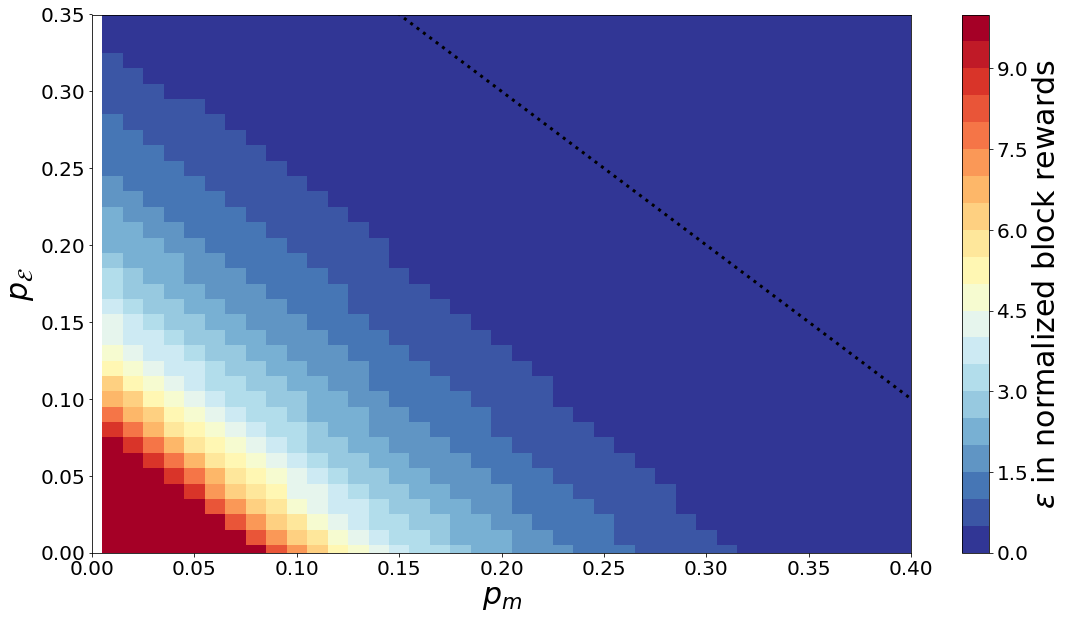

In [248]:
ret_plot=color_mesh_e_min(mode="classic",
                          z=1,
                          p_V=0.0,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.0$ in classic model",
                          save_path="../paper/preprint/figures/e_min_classic.png")
ret_plot.show()

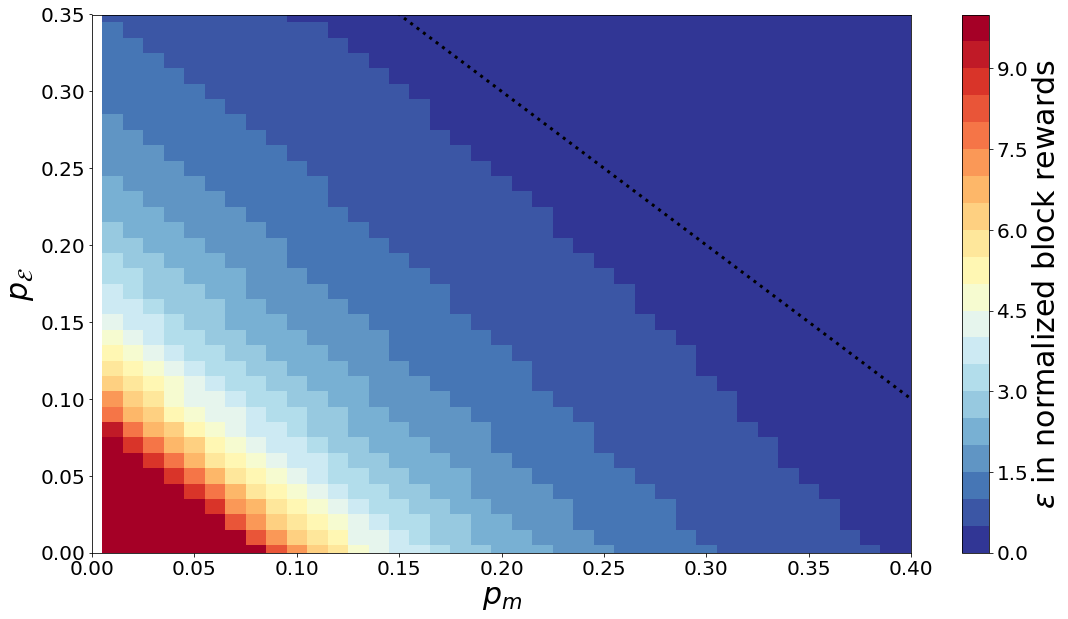

In [249]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.0,
                          kr=1,
                          kl=6,
                          N=6,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.0$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv0.png")
ret_plot.show()

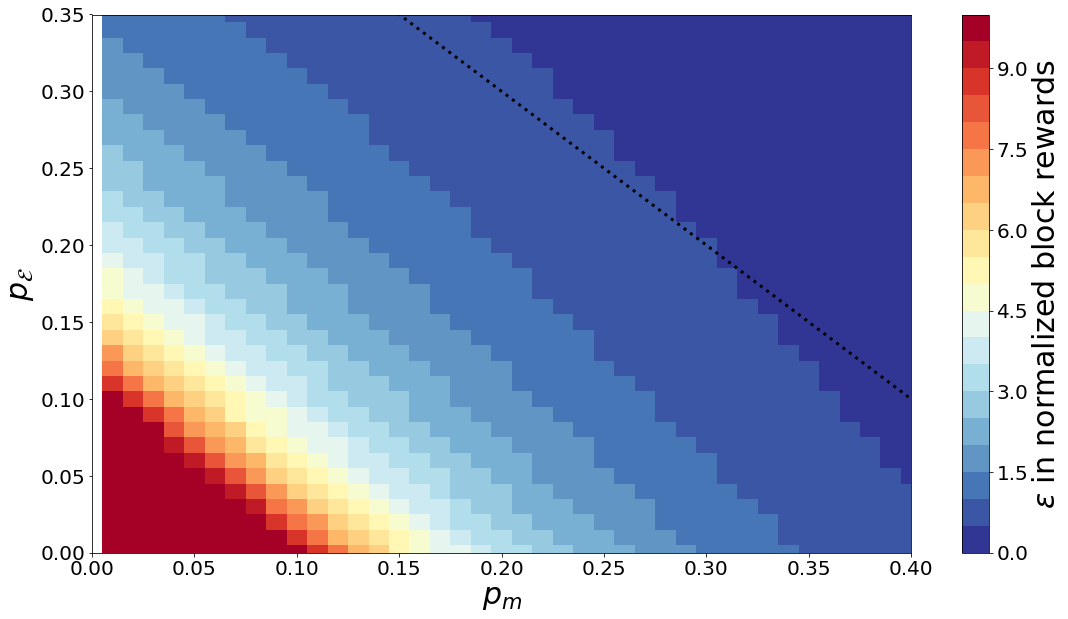

In [250]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25.png")
ret_plot.show()

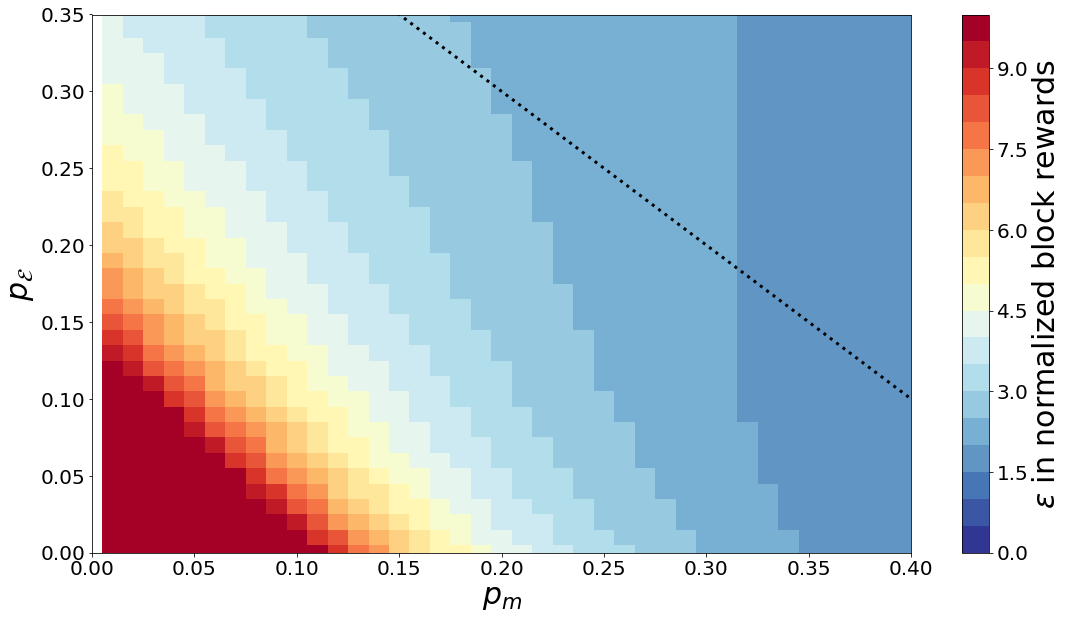

In [251]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=1,
                          n_fork=0,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, \\eta_{main}=1$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_nm1.png")
ret_plot.show()

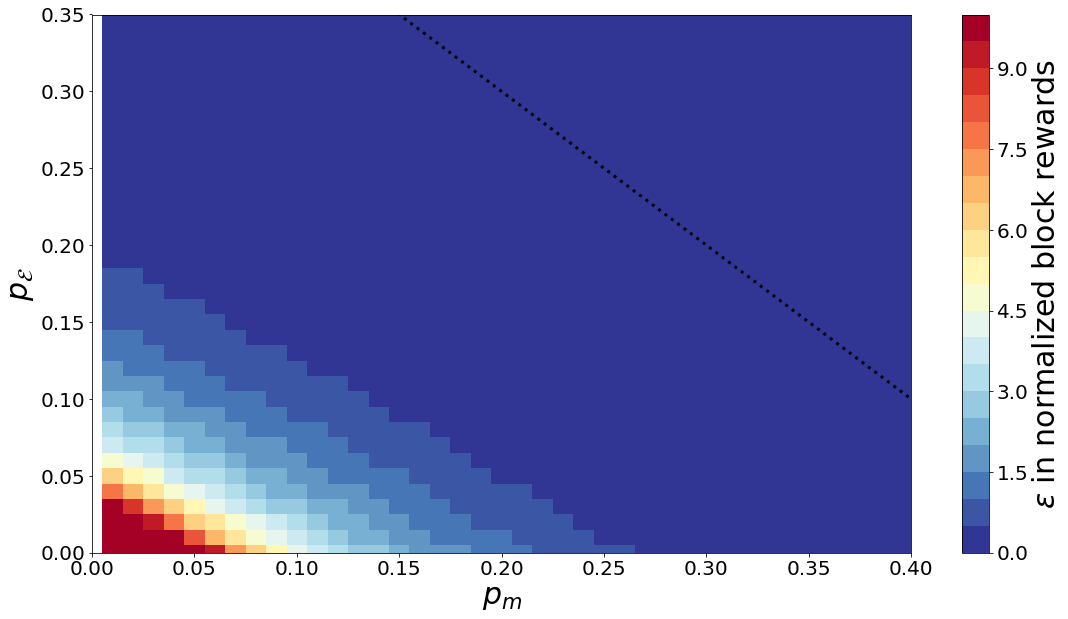

In [252]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=0,
                          n_fork=1,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, \\eta_{main}=1$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_nf1.png")
ret_plot.show()

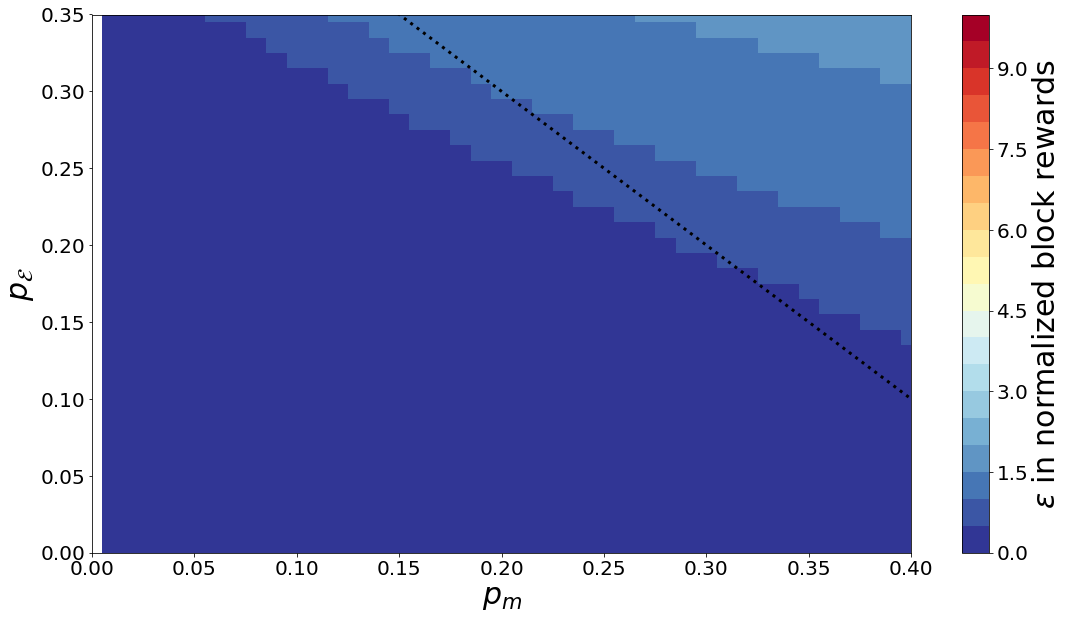

In [253]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=1,
                          n_fork=0,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, \\eta_{main}=1$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_nm1_effort.png")
ret_plot.show()

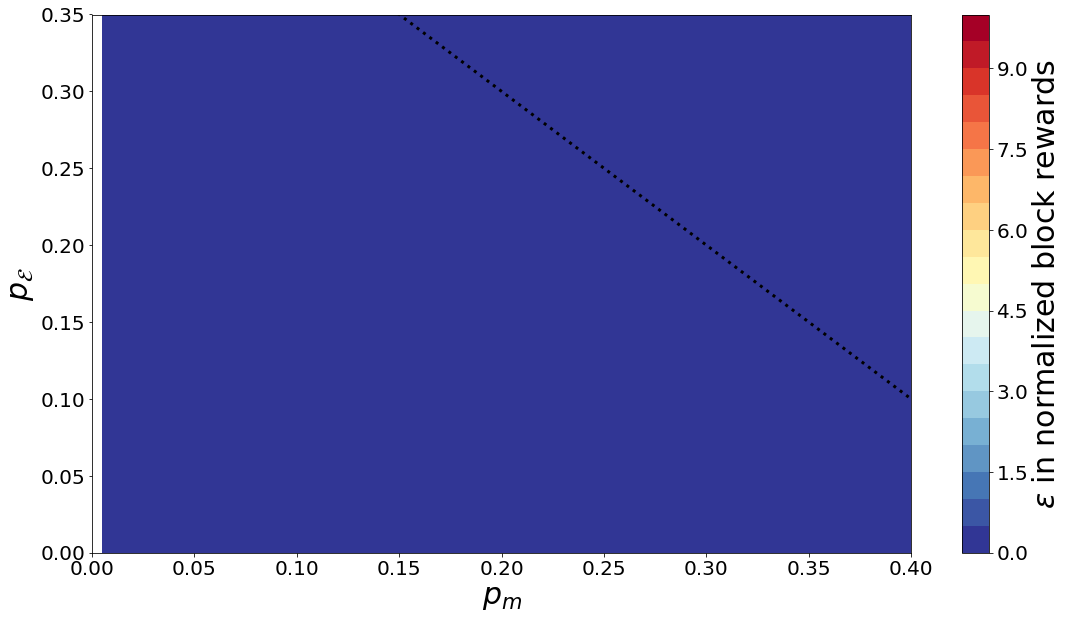

In [254]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=0,
                          n_fork=1,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_nf1_effort.png")
ret_plot.show()

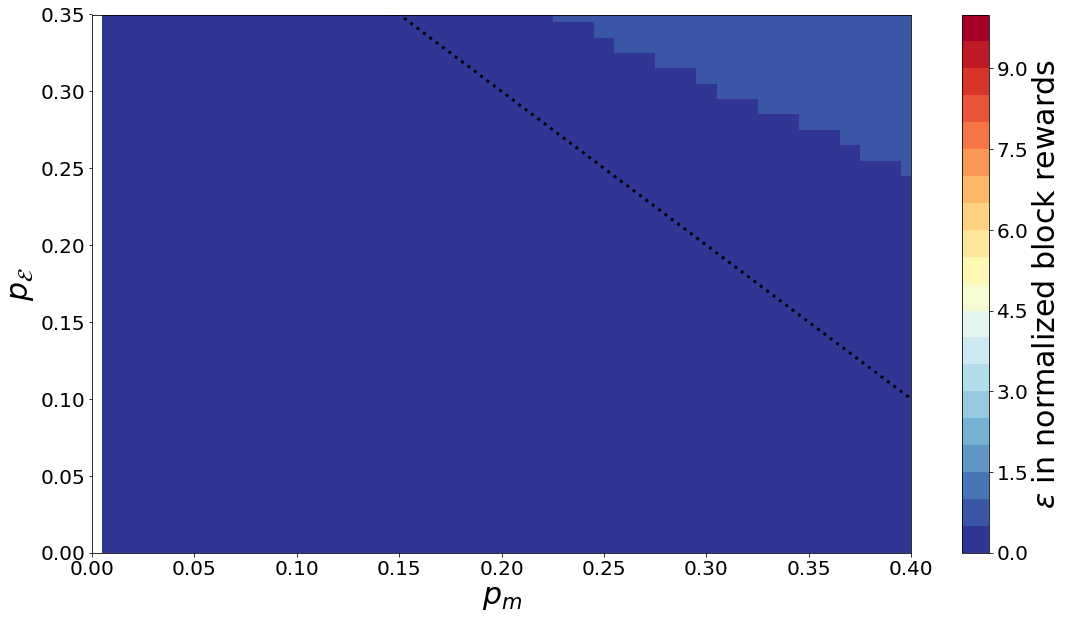

In [255]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=1,
                          n_fork=1,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_nm1_nf1_effort.png")
ret_plot.show()

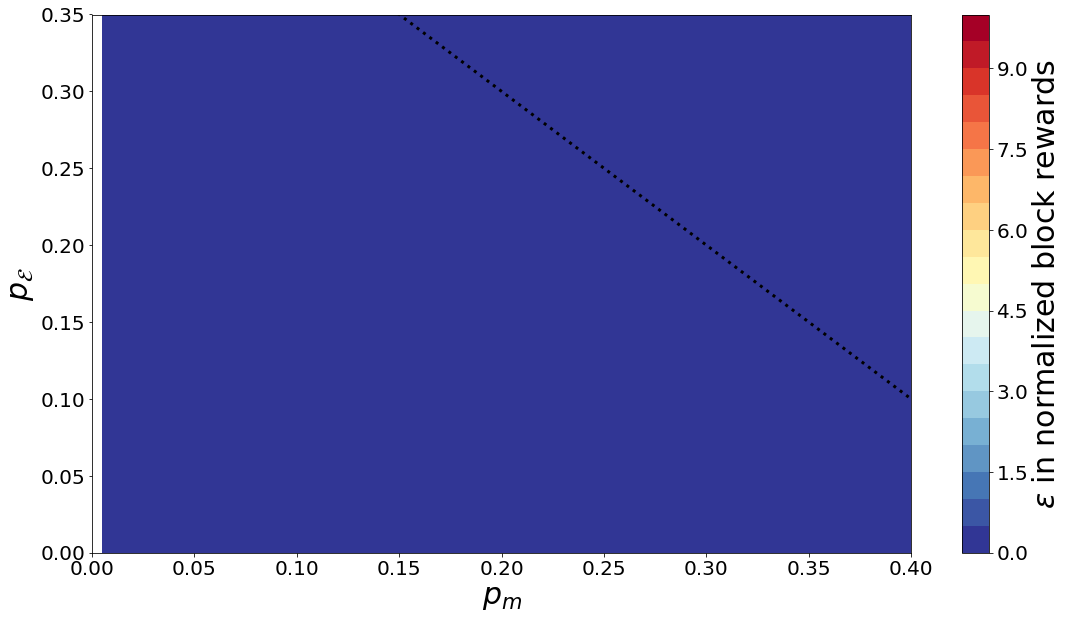

In [256]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=1,
                          p_V=0.25,
                          kr=3,
                          kl=6,
                          N=6,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_effort.png")
ret_plot.show()

### Revision $ z > 1 $

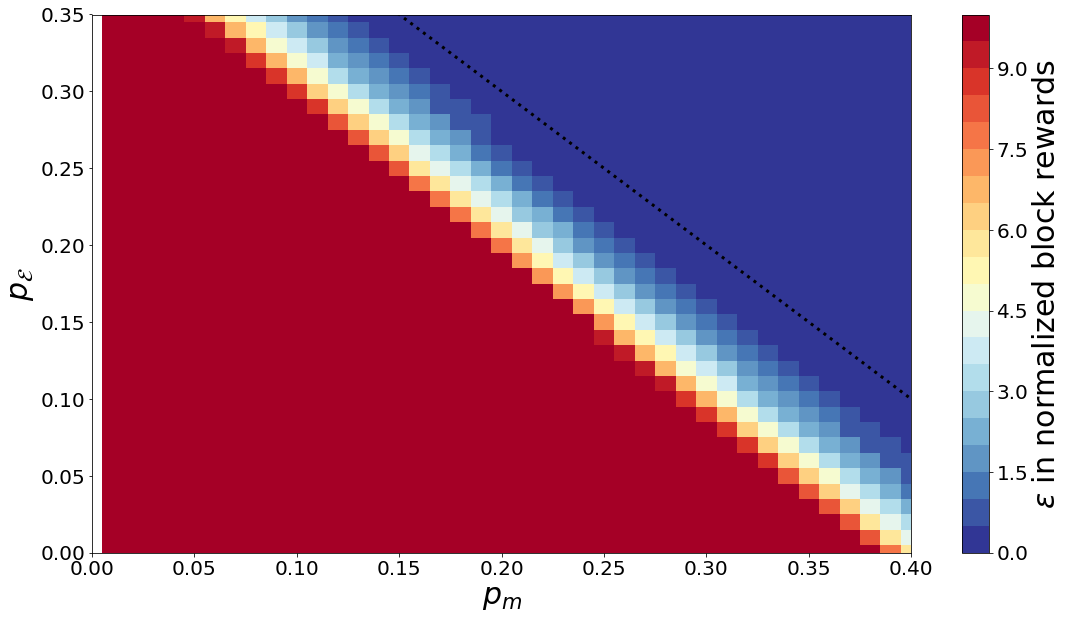

In [257]:
ret_plot=color_mesh_e_min(mode="classic",
                          z=6,
                          p_V=0.0,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.0, z=6$ in classic model",
                          save_path="../paper/preprint/figures/e_min_classic_z6.png")
ret_plot.show()

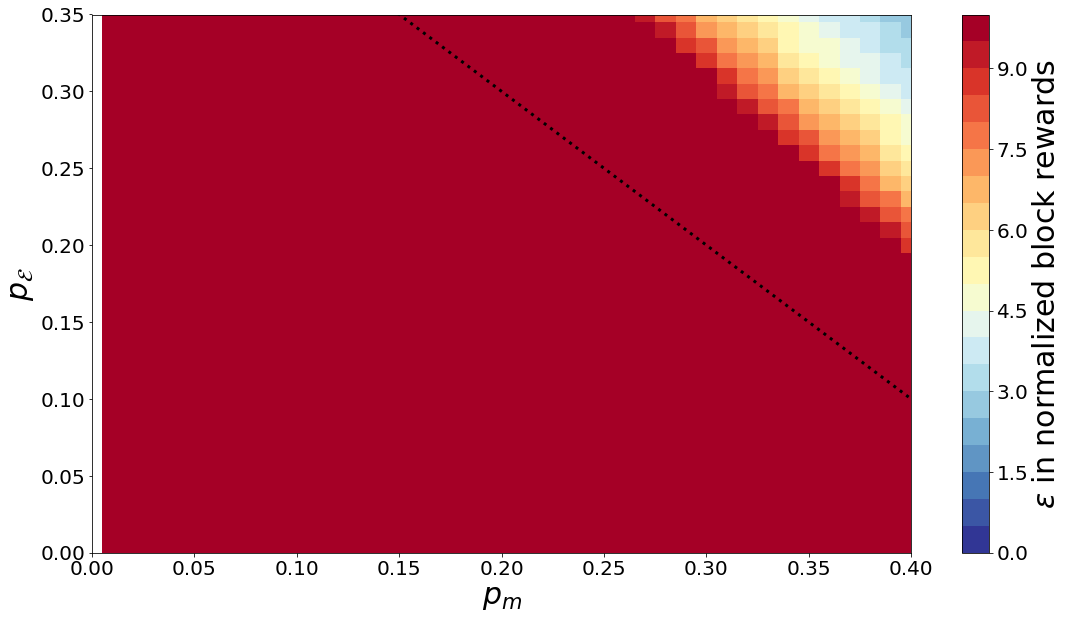

In [258]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0,
                          kr=1,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.0$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv0_z6.png")
ret_plot.show()

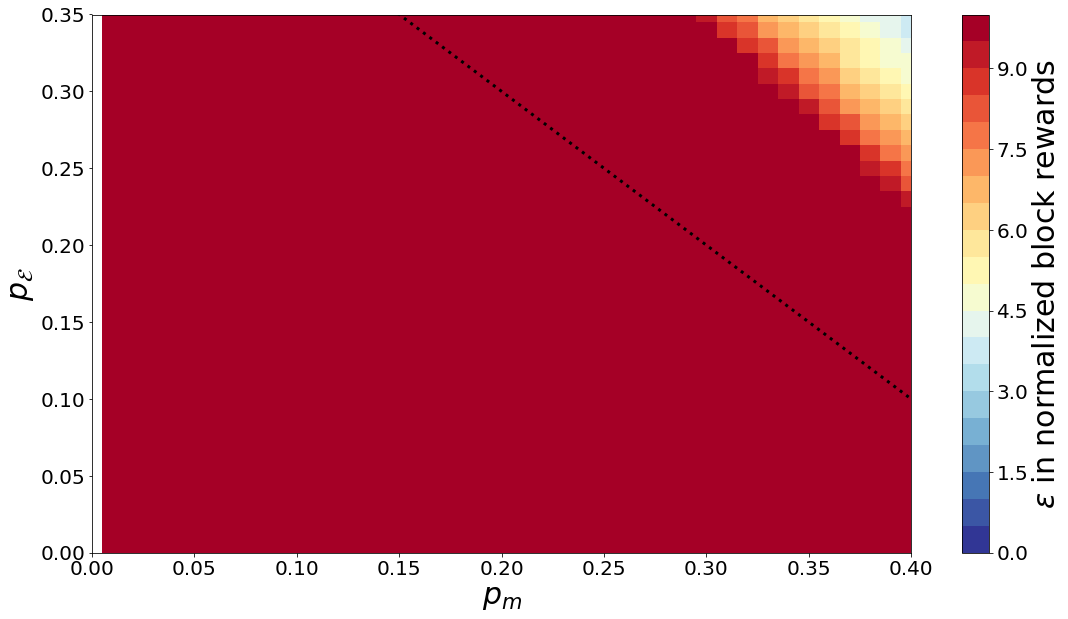

In [259]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, z=6$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6.png")
ret_plot.show()

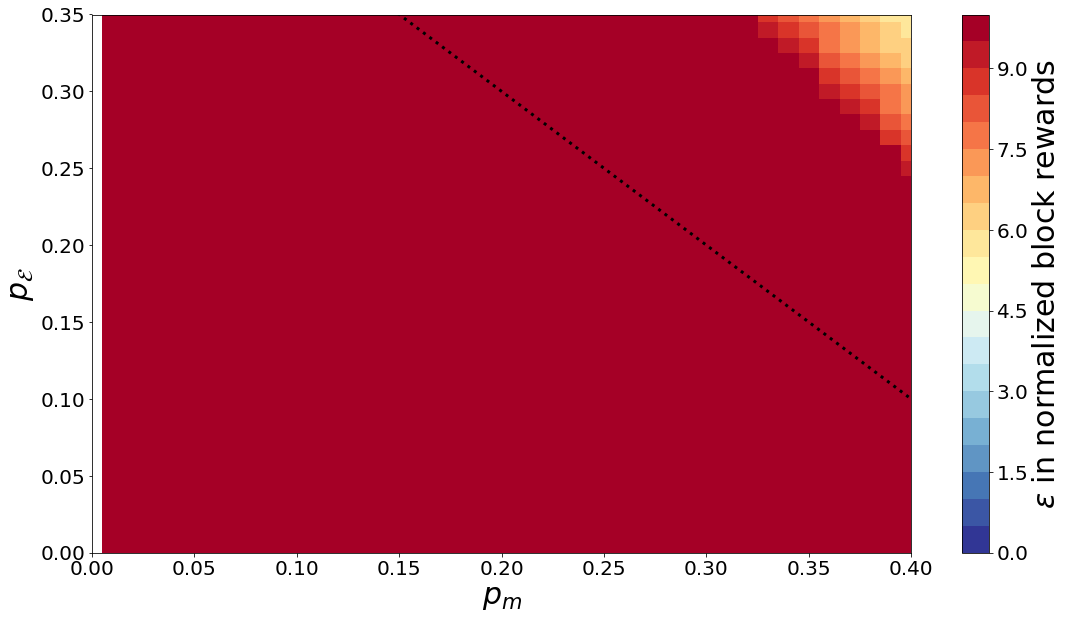

In [260]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=1,
                          n_fork=0,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, z=6$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nm1.png")
ret_plot.show()

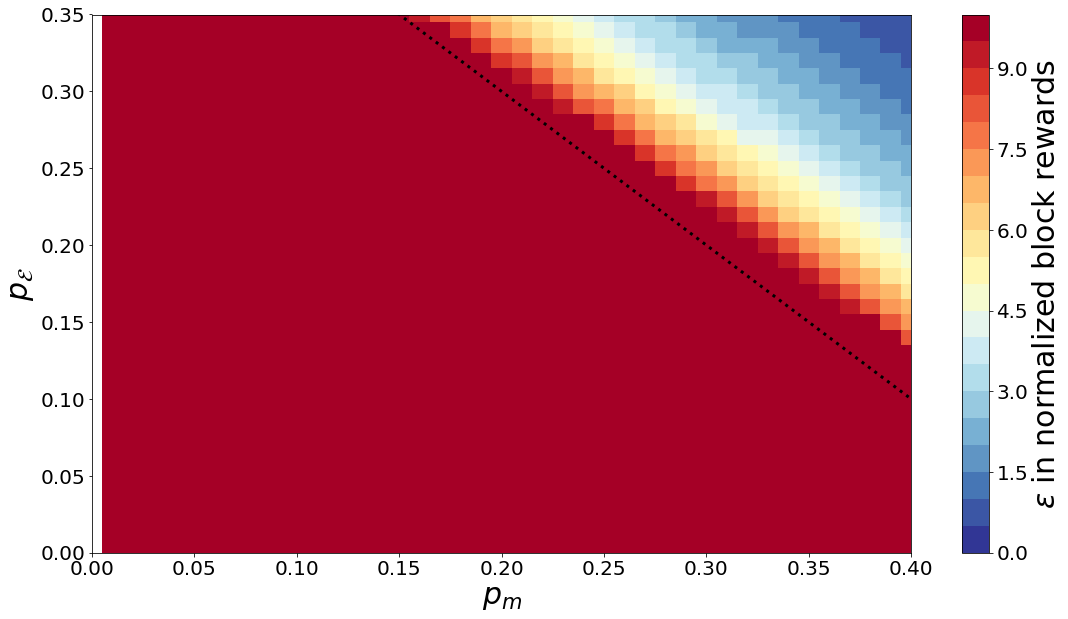

In [261]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=1,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, z=6$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nf1.png")
ret_plot.show()

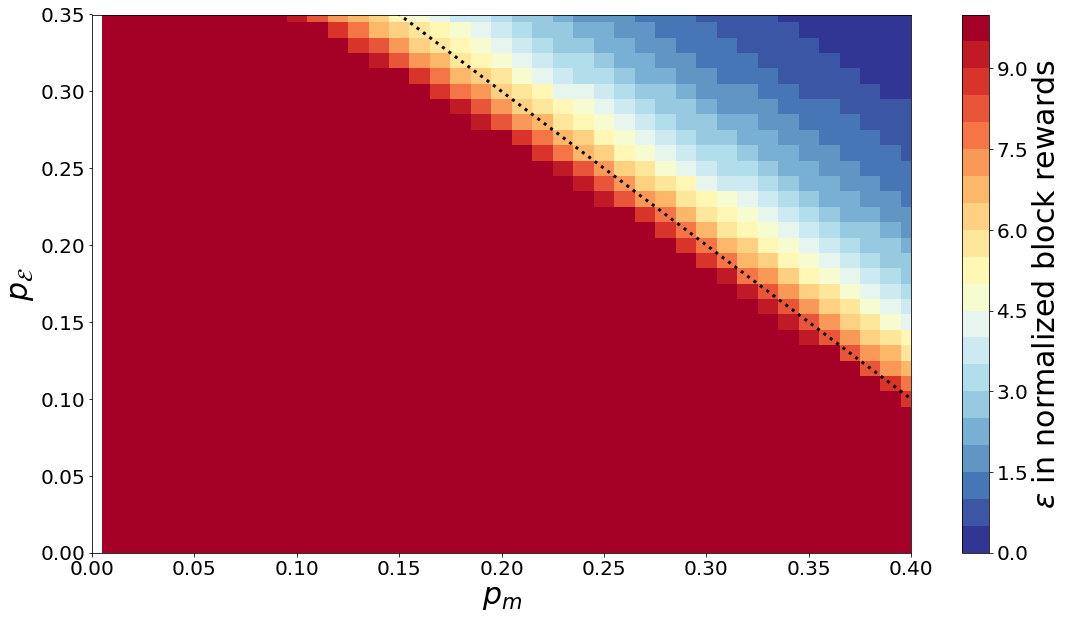

In [262]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=2,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, z=6$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nf2.png")
ret_plot.show()

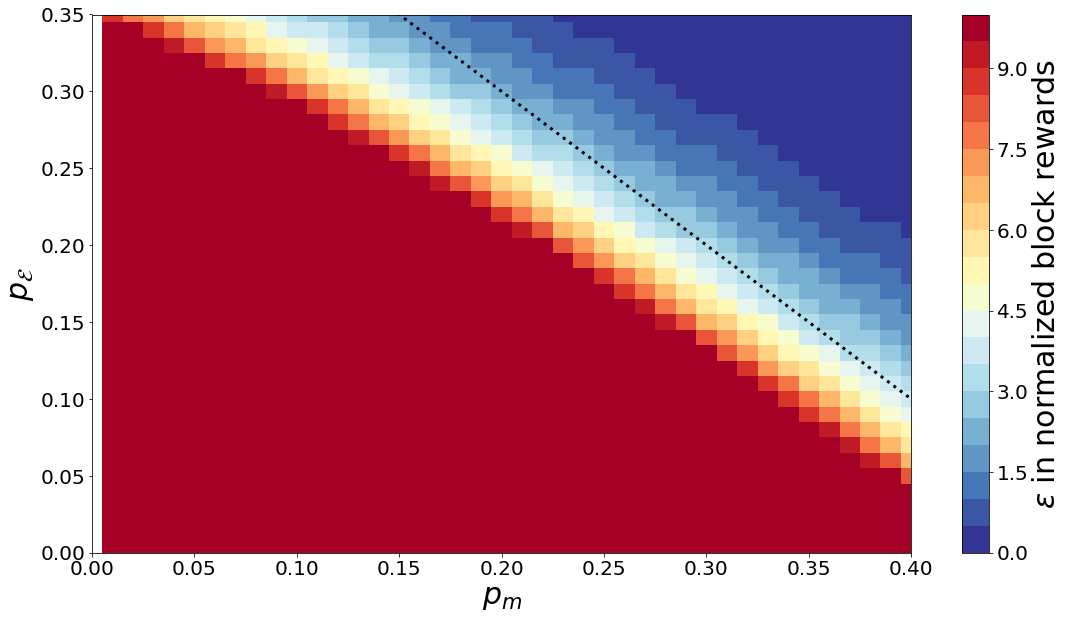

In [263]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=5,
                          expr=e_expr_blocks,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25, z=6$ in markov model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nf3.png")
ret_plot.show()

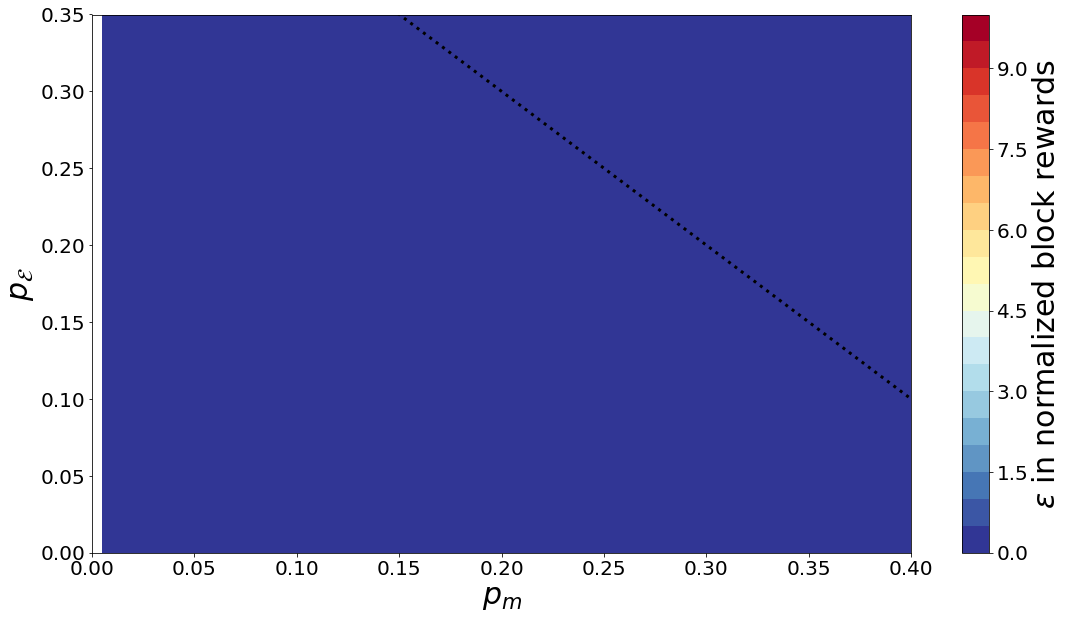

In [264]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0,
                          kr=1,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv0_z6_effort.png")
ret_plot.show()

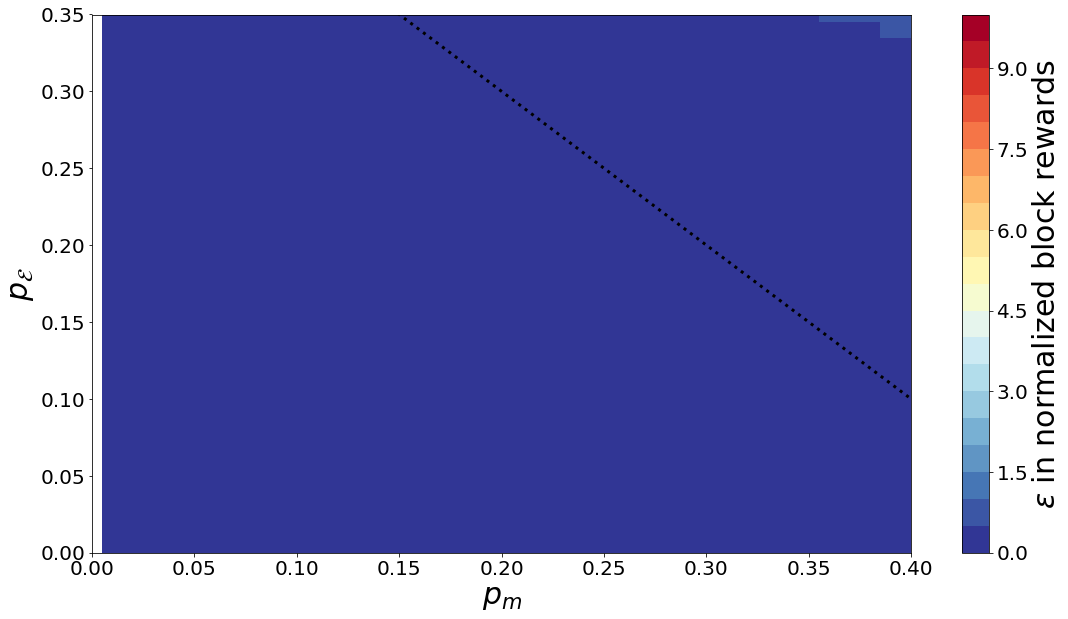

In [265]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=0,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_effort.png")
ret_plot.show()

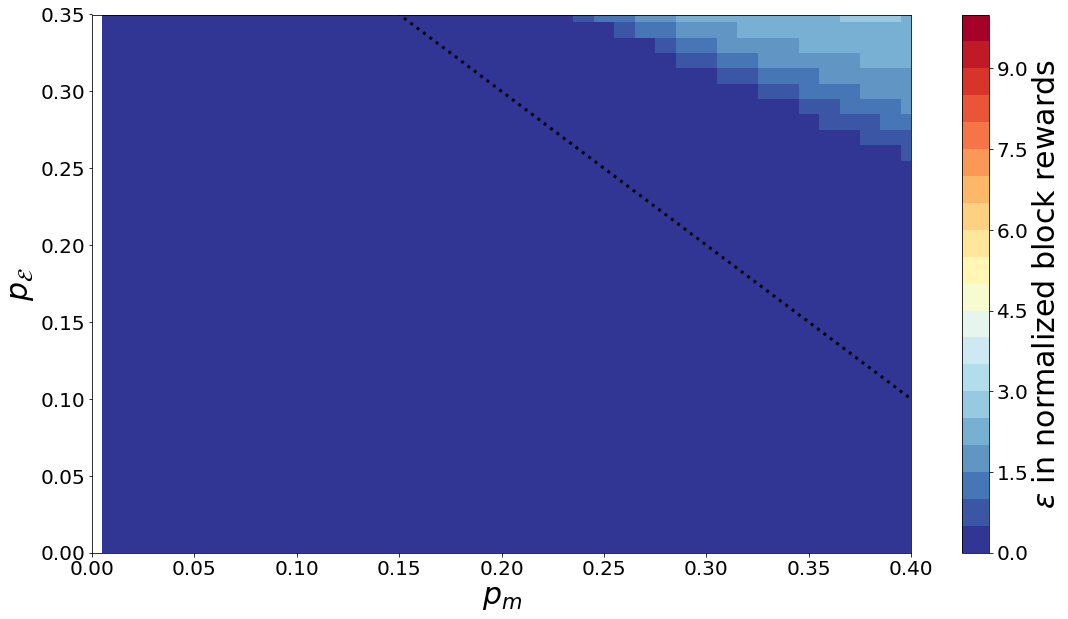

In [266]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=1,
                          n_fork=0,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nm1_effort.png")
ret_plot.show()

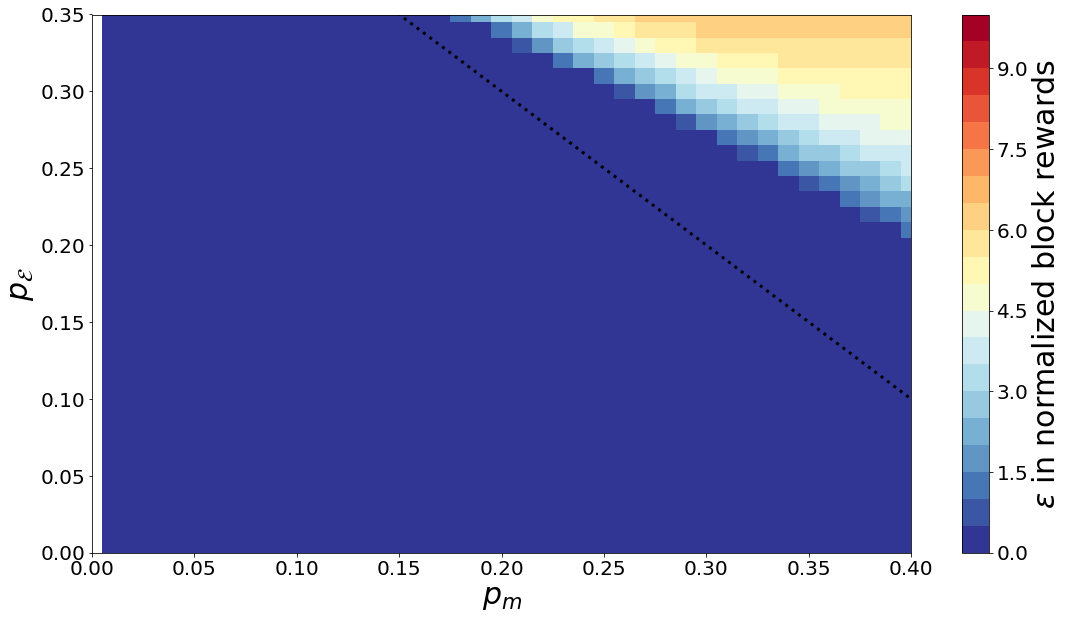

In [267]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=3,
                          n_fork=0,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nm3_effort.png")
ret_plot.show()

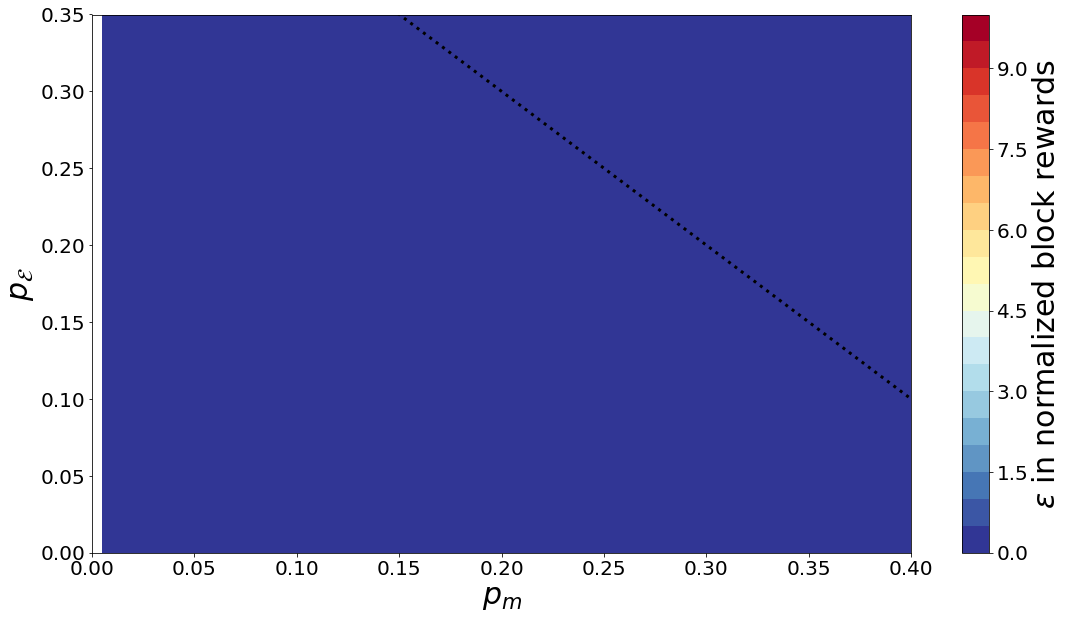

In [268]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=1,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nf1_effort.png")
ret_plot.show()

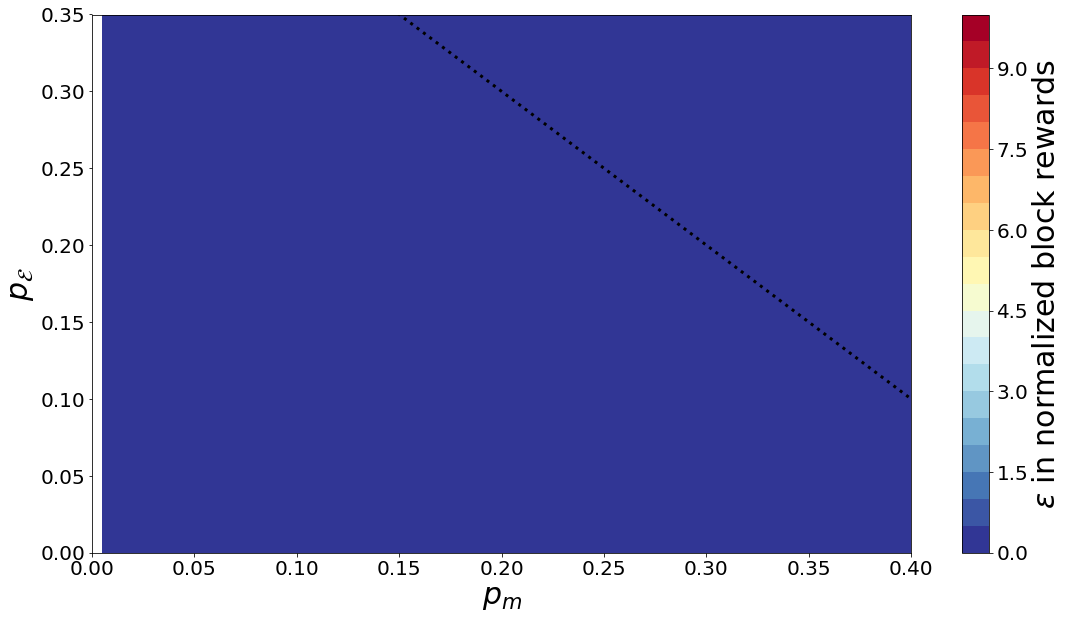

In [269]:
ret_plot=color_mesh_e_min(mode="markov",
                          z=6,
                          p_V=0.25,
                          kr=3,
                          kl=9,
                          N=10,
                          n_main=0,
                          n_fork=3,
                          expr=e_expr_blocks_effort,
                          #title_string="Minimum $\\epsilon$ for $p_\\mathcal{V} = 0.25$ \n in markov effort-related compensation model",
                          save_path="../paper/preprint/figures/e_min_markov_pv25_z6_nf3_effort.png")
ret_plot.show()